# Исследовательский анализ данных Яндекс Афиши
## Часть 2: Анализ пользовательского поведения и проверка гипотез
 
**Автор:** [Кенжебеков Санат]
**Дата:** [06.11.25]


### 🎯 Цели исследования
 
1. **Исследовать изменение пользовательских предпочтений** и популярности событий осенью 2024 года
2. **Проанализировать различия в поведении** пользователей мобильных и стационарных устройств  
3. **Выявить ключевые тренды** и факторы, влияющие на выручку сервиса
4. **Проверить статистические гипотезы** о активности пользователей разных устройств


### 📊 Описание данных
 
В распоряжении 3 датасета:
 
1. **`final_tickets_orders_df.csv`** - заказы билетов
- 292,034 заказа с 1 июня по 31 октября 2024

Первый датасет **final_tickets_orders_df.csv** включает информацию обо всех заказах билетов, совершённых с двух типов устройств — мобильных и стационарных. Поля датасета соответствуют таблице purchases, с которой вы работали в предыдущих заданиях:
- order_id — уникальный идентификатор заказа.
- user_id — уникальный идентификатор пользователя.
- created_dt_msk — дата создания заказа (московское время).
- created_ts_msk — дата и время создания заказа (московское время).
- event_id — идентификатор мероприятия из таблицы events.
- cinema_circuit — сеть кинотеатров. Если не применимо, то здесь будет значение 'нет'.
- age_limit — возрастное ограничение мероприятия.
- currency_code — валюта оплаты, например rub для российских рублей.
- device_type_canonical — тип устройства, с которого был оформлен заказ, например mobile для мобильных устройств, desktop для стационарных.
- revenue — выручка от заказа.
- service_name — название билетного оператора.
- tickets_count — количество купленных билетов.
- total — общая сумма заказа.
В данные также был добавлен столбец days_since_prev с количеством дней с предыдущей покупки для каждого пользователя. Если покупки не было, то данные содержат пропуск.
 
2. **`final_tickets_events_df.csv`** - информация о мероприятиях  
- 22,484 события (исключены фильмы)
- Данные о площадках, городах, регионах

Второй датасет **final_tickets_events_df** содержит информацию о событиях, включая город и регион события, а также информацию о площадке проведения мероприятия. Обратите внимание, что из данных исключили фильмы, ведь, как было видно на дашборде, событий такого типа не так много. Датасет содержит такие поля:
- event_id — уникальный идентификатор мероприятия.
- event_name — название мероприятия. Аналог поля event_name_code из исходной базы данных.
- event_type_description — описание типа мероприятия.
- event_type_main — основной тип мероприятия: театральная постановка, концерт и так далее.
- organizers — организаторы мероприятия.
- region_name — название региона.
- city_name — название города.
- venue_id — уникальный идентификатор площадки.
- venue_name — название площадки.
- venue_address — адрес площадки.
 
3. **`final_tickets_tenge_df.csv`** - курс валют

Анализ данных в предыдущей части проекта показал, что выручка от заказов представлена в двух валютах — российских рублях и казахстанских тенге. Для удобства решения было бы корректно привести данные к одной валюте, например к российским рублям. Для этого в вашем распоряжении будет датасет final_tickets_tenge_df.csv с информацией о курсе тенге к российскому рублю за 2024 год. Значения в рублях представлено для 100 тенге. Датасет содержит такие поля:
- nominal — номинал (100 тенге).
- data — дата.
- curs — курс тенге к рублю.
- cdx — обозначение валюты (kzt).

### 🗂️ Структура проекта
 
1. **Шаг 1** - Загрузка и первичный анализ данных
2. **Шаг 2** - Предобработка данных
3. **Шаг 3** - Исследовательский анализ данных
      - 3.1 Анализ сезонных изменений
      - 3.2 Осенняя активность пользователей  
      - 3.3 Популярные события и партнёры
4. **Шаг 4** - Статистический анализ гипотез
5. **Шаг 5** - Общие выводы и рекомендации


### 📈 Ключевые метрики для анализа
 
- **Выручка с заказа** (`revenue_rub`) - в российских рублях
- **Количество заказов** - общее и по сегментам
- **DAU** - daily active users  
- **Среднее время между заказами** - по пользователям
- **Стоимость билета** (`one_ticket_revenue_rub`) - выручка с одного билета


### 🔍 Основные вопросы исследования
 
1. Как изменились пользовательские предпочтения с лета на осень?
2. В чем различия поведения mobile и desktop пользователей?
3. Какие типы мероприятий наиболее популярны в разные сезоны?
4. Какие регионы и партнёры приносят наибольшую выручку?

## Шаг 1. Знакомство с данными.

In [1]:
# Импорт необходимых библиотек

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import scipy.stats as stats
from warnings import filterwarnings
filterwarnings('ignore')
from scipy.stats import mannwhitneyu
from scipy.stats import shapiro

In [2]:
# Шаг 1.1: Загрузка данных
print("ШАГ 1.1: ЗАГРУЗКА ДАННЫХ")
orders_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_orders_df.csv')
events_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_events_df.csv')
tenge_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

print("✅ Данные загружены успешно")
print(f"orders_df: {orders_df.shape[0]} строк, {orders_df.shape[1]} столбцов")
print(f"events_df: {events_df.shape[0]} строк, {events_df.shape[1]} столбцов") 
print(f"tenge_df: {tenge_df.shape[0]} строк, {tenge_df.shape[1]} столбцов\n")

ШАГ 1.1: ЗАГРУЗКА ДАННЫХ
✅ Данные загружены успешно
orders_df: 290849 строк, 14 столбцов
events_df: 22427 строк, 11 столбцов
tenge_df: 357 строк, 4 столбцов



In [3]:
# Шаг 1.2: head() каждого датасета
print("ШАГ 1.2: ПЕРВЫЕ СТРОКИ ДАННЫХ")

print("📊 orders_df (заказы):")
display(orders_df.head(3))

print("\n📊 events_df (мероприятия):")
display(events_df.head(3))

print("\n📊 tenge_df (курс валют):")
display(tenge_df.head(3))

ШАГ 1.2: ПЕРВЫЕ СТРОКИ ДАННЫХ
📊 orders_df (заказы):


,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0



📊 events_df (мероприятия):


,event_id,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4436,e4f26fba-da77-4c61-928a-6c3e434d793f,спектакль,театр,№4893,Североярская область,Озёрск,2,1600,"Кладбище искусств ""Проблема"" и партнеры","наб. Загородная, д. 785"
1,5785,5cc08a60-fdea-4186-9bb2-bffc3603fb77,спектакль,театр,№1931,Светополянский округ,Глиноград,54,2196,"Лекции по искусству ""Свет"" Групп","ул. Ягодная, д. 942"
2,8817,8e379a89-3a10-4811-ba06-ec22ebebe989,спектакль,театр,№4896,Североярская область,Озёрск,2,4043,"Кинокомитет ""Золотая"" Инк","ш. Коммуны, д. 92 стр. 6"



📊 tenge_df (курс валют):


,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt


In [4]:
# Шаг 1.3: info() каждого датасета
print("ШАГ 1.3: ИНФОРМАЦИЯ О ДАННЫХ")

print("📋 orders_df.info():")
orders_df.info()

print("\n📋 events_df.info():")
events_df.info()

print("\n📋 tenge_df.info():")
tenge_df.info()

ШАГ 1.3: ИНФОРМАЦИЯ О ДАННЫХ
📋 orders_df.info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   order_id               290849 non-null  int64  
 1   user_id                290849 non-null  object 
 2   created_dt_msk         290849 non-null  object 
 3   created_ts_msk         290849 non-null  object 
 4   event_id               290849 non-null  int64  
 5   cinema_circuit         290849 non-null  object 
 6   age_limit              290849 non-null  int64  
 7   currency_code          290849 non-null  object 
 8   device_type_canonical  290849 non-null  object 
 9   revenue                290849 non-null  float64
 10  service_name           290849 non-null  object 
 11  tickets_count          290849 non-null  int64  
 12  total                  290849 non-null  float64
 13  days_since_prev        268909 non-null  

### Шаг 1.4: Промежуточные выводы

📊 ОБЪЕМ ДАННЫХ:
- orders_df: 290,849 заказов, 14 столбцов
- events_df: 22,427 мероприятий, 11 столбцов  
- tenge_df: 357 записей курса валют, 4 столбца

✅ КОРРЕКТНОСТЬ ДАННЫХ И СООТВЕТСТВИЕ ОПИСАНИЮ:
- Соответствие описанию: ✓ все заявленные поля присутствуют
- Типы устройств: только mobile/desktop - соответствует условию
- Фильмы исключены: ✓ в events_df нет типа 'фильм'
- Период данных: с июня по октябрь 2024 - соответствует заданию

⚠️ ОБНАРУЖЕННЫЕ ОСОБЕННОСТИ:

1. ТИПЫ ДАННЫХ:
   - created_dt_msk, created_ts_msk, data (в tenge_df) - object (нужна конвертация в datetime)
   - age_limit - int64 (ожидали categorical)
   - user_id - object (хэшированные значения)

2. ПРОПУСКИ:
   - days_since_prev: 21,940 пропусков (7.5%) - ожидаемо для первых покупок
   - Остальные поля: пропусков нет

3. СТРУКТУРА ДАННЫХ:
   - events_df: 11 столбцов (в описании было 10) - добавлен venue_address
   - user_id: анонимизированы (хэши)
   - event_name: закодированы (UUID)

ЗАДАЧИ ДЛЯ ПРЕДОБРАБОТКИ (ШАГ 2):

1. КОНВЕРТАЦИЯ ДАТ:
   - created_dt_msk, created_ts_msk → datetime
   - data в tenge_df → datetime

2. КОНВЕРТАЦИЯ ВАЛЮТ:
   - Объединить orders_df с tenge_df по дате
   - Создать revenue_rub (выручка в рублях)
   - Рассчитать one_ticket_revenue_rub

3. ПРЕОБРАЗОВАНИЕ ТИПОВ:
   - age_limit → category (возрастные ограничения)
   - currency_code, device_type_canonical → category

4. СОЗДАНИЕ НОВЫХ ПРИЗНАКОВ:
   - month - месяц заказа
   - season - сезон ('лето', 'осень')

5. ОБЪЕДИНЕНИЕ ДАННЫХ:
   - Объединить orders_df с events_df по event_id

6. АНАЛИЗ ВЫБРОСОВ:
   - Проверить распределение revenue и tickets_count
   - Рассмотреть отсечение по 99-му процентилю для выручки

7. ПРОВЕРКА ДУБЛИКАТОВ:
   - Убедиться в уникальности order_id
   - Проверить явные и неявные дубликаты

   __________________________________________________________________________________________________________________________________________________

## Шаг 2. Предобработка данных.

In [5]:
# Шаг 2.1: Проверка пропусков
print("ШАГ 2.1: ПРОВЕРКА ПРОПУСКОВ")

print("Пропуски в orders_df:")
print(orders_df.isnull().sum())
print(f"\nПропуски в days_since_prev: {orders_df['days_since_prev'].isnull().sum()} ({orders_df['days_since_prev'].isnull().mean()*100:.1f}%)")

print("\nПропуски в events_df:")
print(events_df.isnull().sum())

print("\nПропуски в tenge_df:")
print(tenge_df.isnull().sum())

ШАГ 2.1: ПРОВЕРКА ПРОПУСКОВ
Пропуски в orders_df:
order_id                     0
user_id                      0
created_dt_msk               0
created_ts_msk               0
event_id                     0
cinema_circuit               0
age_limit                    0
currency_code                0
device_type_canonical        0
revenue                      0
service_name                 0
tickets_count                0
total                        0
days_since_prev          21940
dtype: int64

Пропуски в days_since_prev: 21940 (7.5%)

Пропуски в events_df:
event_id                  0
event_name                0
event_type_description    0
event_type_main           0
organizers                0
region_name               0
city_name                 0
city_id                   0
venue_id                  0
venue_name                0
venue_address             0
dtype: int64

Пропуски в tenge_df:
data       0
nominal    0
curs       0
cdx        0
dtype: int64


ОСНОВНЫЕ ДАННЫЕ БЕЗ ПРОПУСКОВ:
- orders_df: Все ключевые поля (order_id, user_id, event_id, revenue и др.) не содержат пропусков
- events_df: Полностью заполненные данные о мероприятиях
- tenge_df: Полные данные о курсе валют

ЕДИНСТВЕННЫЕ ПРОПУСКИ:
• days_since_prev: 21,940 пропусков (7.5% от всех заказов)

ПРИЧИНА ПРОПУСКОВ В days_since_prev:
- Это ОЖИДАЕМЫЕ пропуски для ПЕРВЫХ ПОКУПОК каждого пользователя
- Поле days_since_prev рассчитывается как разница с предыдущим заказом
- Для первого заказа пользователя предыдущего заказа не существует → значение NaN
- Это нормальное поведение данных и не требует исправления

In [6]:
# Шаг 2.2: Анализ ВСЕХ категориальных столбцов
print("ШАГ 2.2: АНАЛИЗ ВСЕХ КАТЕГОРИАЛЬНЫХ СТОЛБЦОВ")

print("=== ORDERS_DF ===")
print("currency_code:")
print(orders_df['currency_code'].value_counts())
print(f"Аномалии: {'нет' if set(orders_df['currency_code'].unique()) == {'rub', 'kzt'} else 'есть'}")

print("\ndevice_type_canonical:")
print(orders_df['device_type_canonical'].value_counts())
print(f"Аномалии: {'нет' if set(orders_df['device_type_canonical'].unique()) == {'mobile', 'desktop'} else 'есть'}")

print("\nage_limit:")
print(orders_df['age_limit'].value_counts().sort_index())
print(f"Аномалии: {'нет' if set(orders_df['age_limit'].unique()) == {0, 6, 12, 16, 18} else 'есть'}")

print("\ncinema_circuit:")
print(orders_df['cinema_circuit'].value_counts().head(10))  # Топ-10 значений
print(f"Уникальных значений: {orders_df['cinema_circuit'].nunique()}")
print(f"Аномалии: {'нет' if orders_df['cinema_circuit'].str.contains('нет').sum() > 0 else 'проверить'}")

print("\nservice_name:")
print(orders_df['service_name'].value_counts().head(10))  # Топ-10 операторов
print(f"Уникальных операторов: {orders_df['service_name'].nunique()}")
print(f"Аномалии: {'нет' if orders_df['service_name'].notna().all() else 'есть пропуски'}")

print("\n=== EVENTS_DF ===")
print("event_type_main:")
print(events_df['event_type_main'].value_counts())
print(f"Аномалии: {'нет' if 'фильм' not in events_df['event_type_main'].unique() else 'фильмы не исключены'}")

print("\nevent_type_description:")
print(events_df['event_type_description'].value_counts().head(10))
print(f"Уникальных описаний: {events_df['event_type_description'].nunique()}")

print("\norganizers:")
print(events_df['organizers'].value_counts().head(10))
print(f"Уникальных организаторов: {events_df['organizers'].nunique()}")

print("\nregion_name:")
print(events_df['region_name'].value_counts().head(10))
print(f"Уникальных регионов: {events_df['region_name'].nunique()}")

print("\ncity_name:")
print(events_df['city_name'].value_counts().head(10))
print(f"Уникальных городов: {events_df['city_name'].nunique()}")

print("\nvenue_name:")
print(events_df['venue_name'].value_counts().head(10))
print(f"Уникальных площадок: {events_df['venue_name'].nunique()}")

print("\n=== TENGE_DF ===")
print("cdx:")
print(tenge_df['cdx'].value_counts())
print(f"Аномалии: {'нет' if set(tenge_df['cdx'].unique()) == {'kzt'} else 'есть'}")

print("\nnominal:")
print(tenge_df['nominal'].value_counts())
print(f"Аномалии: {'нет' if set(tenge_df['nominal'].unique()) == {100} else 'есть'}")

ШАГ 2.2: АНАЛИЗ ВСЕХ КАТЕГОРИАЛЬНЫХ СТОЛБЦОВ
=== ORDERS_DF ===
currency_code:
currency_code
rub    285780
kzt      5069
Name: count, dtype: int64
Аномалии: нет

device_type_canonical:
device_type_canonical
mobile     232679
desktop     58170
Name: count, dtype: int64
Аномалии: нет

age_limit:
age_limit
0     61487
6     52173
12    62557
16    78579
18    36053
Name: count, dtype: int64
Аномалии: нет

cinema_circuit:
cinema_circuit
нет           289451
Другое          1261
КиноСити         122
Киномакс           7
Москино            7
ЦентрФильм         1
Name: count, dtype: int64
Уникальных значений: 6
Аномалии: нет

service_name:
service_name
Билеты без проблем    63709
Лови билет!           41126
Билеты в руки         40364
Мой билет             34843
Облачко               26642
Лучшие билеты         17795
Весь в билетах        16849
Прачечная             10273
Край билетов           6207
Тебе билет!            5228
Name: count, dtype: int64
Уникальных операторов: 36
Аномалии: нет



### Выводы по анализу всех категориальных признаков

✅ НОРМАЛЬНЫЕ ПОЛЯ (без аномалий):
- currency_code: только RUB и KZT - соответствует ожиданиям
- device_type_canonical: только mobile и desktop - соответствует фильтрации
- age_limit: корректные возрастные ограничения (0, 6, 12, 16, 18)
- cdx: только KZT - корректно
- nominal: только 100 - корректно

🔍 ТРЕБУЮТ ВНИМАНИЯ:
- cinema_circuit: много уникальных значений, преобладает 'нет' - вероятно, для некинематографических мероприятий
- service_name: 36 уникальных операторов, есть доминирующие игроки
- event_type_description: разнообразные описания типов мероприятий
- organizers: множество уникальных организаторов
- region_name/city_name: географическое разнообразие (81 регион, 352 города)
- venue_name: множество уникальных площадок

⚠️ ПОТЕНЦИАЛЬНЫЕ ПРОБЛЕМЫ:
- Высокая концентрация: несколько операторов/регионов доминируют
- Разнообразие: множество уникальных значений в organizers, venue_name может усложнять анализ
- cinema_circuit: значение 'нет' может означать отсутствие данных

🎯 РЕКОМЕНДАЦИИ ДЛЯ АНАЛИЗА:
1. Для service_name, region_name - использовать топ-N категорий, остальные объединять в "другие"
2. cinema_circuit: преобразовать в бинарный признак (есть/нет сеть кинотеатров)
3. organizers: рассматривать как справочную информацию, а не для анализа

In [7]:
# Дополнительная проверка на скрытые аномалии
print("\n🔎 ДОПОЛНИТЕЛЬНЫЕ ПРОВЕРКИ:")

# Проверка на странные значения в текстовых полях
print("Проверка специальных значений в cinema_circuit:")
special_values = orders_df['cinema_circuit'].str.contains(r'[?\-\\/]|unknown|none|null|undefined', case=False, na=False)
print(f"Странные значения: {special_values.sum()}")

print("Проверка длинных/коротких названий в service_name:")
name_lengths = orders_df['service_name'].str.len()
print(f"Средняя длина названия: {name_lengths.mean():.1f} символов")
print(f"Минимальная длина: {name_lengths.min()} символов")
print(f"Максимальная длина: {name_lengths.max()} символов")


🔎 ДОПОЛНИТЕЛЬНЫЕ ПРОВЕРКИ:
Проверка специальных значений в cinema_circuit:
Странные значения: 0
Проверка длинных/коротких названий в service_name:
Средняя длина названия: 12.5 символов
Минимальная длина: 6 символов
Максимальная длина: 22 символов


In [8]:
# Шаг 2.3: Анализ количественных показателей (раздельно по валютам)
print("ШАГ 2.3: АНАЛИЗ КОЛИЧЕСТВЕННЫХ ПОКАЗАТЕЛЕЙ")

print("📊 RUB заказы - revenue:")
rub_revenue = orders_df[orders_df['currency_code'] == 'rub']['revenue']
print(rub_revenue.describe())

print("\n📊 KZT заказы - revenue:")
kzt_revenue = orders_df[orders_df['currency_code'] == 'kzt']['revenue'] 
print(kzt_revenue.describe())

print("\n🎫 tickets_count (все заказы):")
print(orders_df['tickets_count'].describe())
print(f"Уникальные значения: {sorted(orders_df['tickets_count'].unique())}")

# Анализ и комментарии
print("\n🔍 АНАЛИЗ КОЛИЧЕСТВЕННЫХ ПОКАЗАТЕЛЕЙ:")

print(f"""
💰 ВЫРУЧКА (REVENUE):
• RUB: средняя {rub_revenue.mean():.2f}, медиана {rub_revenue.median():.2f} (сильный перекос вправо)
• KZT: средняя {kzt_revenue.mean():.2f}, медиана {kzt_revenue.median():.2f} (более равномерное распределение)
• Разница валют: KZT в ~9 раз больше RUB по средней выручке (логично - разный номинал)

🎫 БИЛЕТЫ (TICKETS_COUNT):
• Среднее: {orders_df['tickets_count'].mean():.2f} билета на заказ
• Медиана: {orders_df['tickets_count'].median():.0f} билета - типичный заказ
• Распределение: 1-4 билета (75% заказов), но есть экстремальные значения до 57 билетов

⚠️ ПОТЕНЦИАЛЬНЫЕ ПРОБЛЕМЫ:
• Отрицательные значения в RUB: min = {rub_revenue.min():.2f} (возможные возвраты)
• Нулевые значения в KZT: min = {kzt_revenue.min():.2f} (бесплатные билеты?)
• Сильный разброс значений в обеих валютах
""")

ШАГ 2.3: АНАЛИЗ КОЛИЧЕСТВЕННЫХ ПОКАЗАТЕЛЕЙ
📊 RUB заказы - revenue:
count    285780.000000
mean        547.568333
std         871.524559
min         -90.760000
25%         113.827500
50%         346.100000
75%         791.700000
max       81174.540000
Name: revenue, dtype: float64

📊 KZT заказы - revenue:
count     5069.000000
mean      4995.206767
std       4916.752776
min          0.000000
25%        518.100000
50%       3698.830000
75%       7397.660000
max      26425.860000
Name: revenue, dtype: float64

🎫 tickets_count (все заказы):
count    290849.000000
mean          2.754230
std           1.170467
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          57.000000
Name: tickets_count, dtype: float64
Уникальные значения: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(17), 

ШАГ 2.4: ВИЗУАЛИЗАЦИЯ РАСПРЕДЕЛЕНИЙ


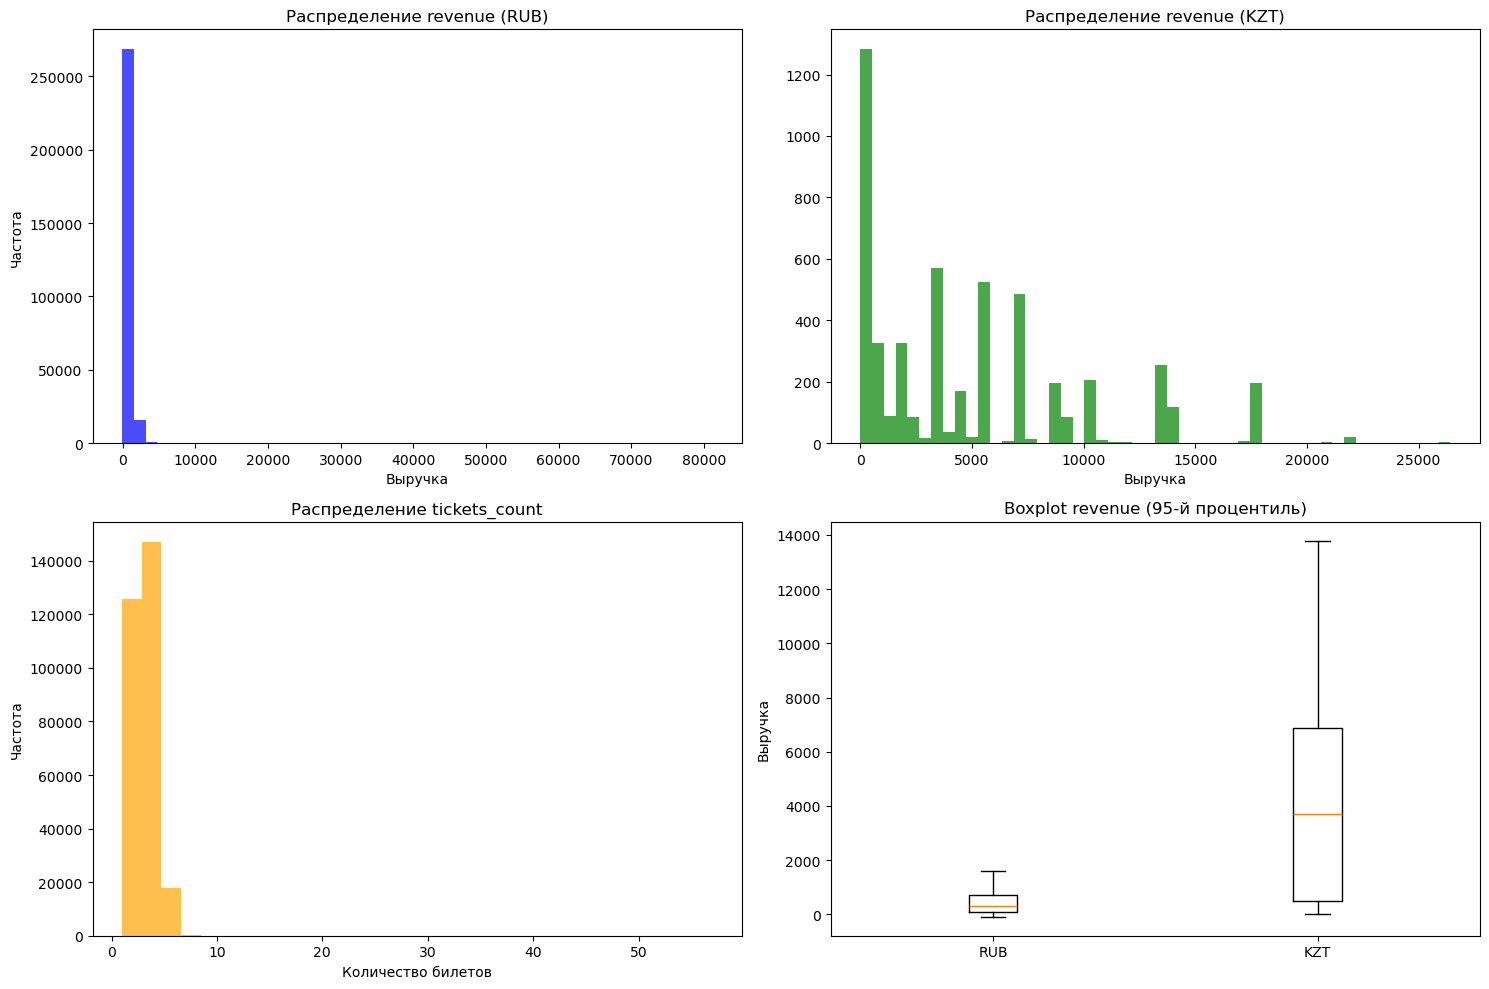

📊 АНАЛИЗ ВЫБРОСОВ ПО ПЕРЦЕНТИЛЯМ:
Перцентили revenue RUB: ['90.0%: 1276.15', '95.0%: 1606.50', '99.0%: 2569.59', '99.9%: 5140.78']
Перцентили revenue KZT: ['90.0%: 13212.93', '95.0%: 13784.26', '99.0%: 17617.24', '99.9%: 22021.55']
Перцентили tickets_count: ['90.0%: 4.0', '95.0%: 5.0', '99.0%: 6.0', '99.9%: 6.0']

99-й процентиль revenue RUB: 2569.59
99-й процентиль revenue KZT: 17617.24
99-й процентиль tickets_count: 6.0

🔍 ЭКСТРЕМАЛЬНЫЕ ЗНАЧЕНИЯ:
RUB заказы > 10,000: 97 шт. (0.034%)
KZT заказы > 20,000: 29 шт. (0.572%)
Заказы с >10 билетов: 48 шт. (0.017%)

🎯 ВЫВОДЫ О ВЫБРОСАХ И ОБРАБОТКЕ:

✅ ВЫБРОСЫ ПРИСУТСТВУЮТ:
• Revenue: сильные выбросы в обеих валютах (максимумы значительно превышают 99-й процентиль)
• Tickets_count: экстремальные значения до 57 билетов в одном заказе

⚠️ ПРОБЛЕМНЫЕ СЛУЧАИ:
• Отрицательная выручка: 381 заказов (возвраты)
• Нулевая выручка: 5737 заказов (бесплатные билеты)
• Большие заказы: 48 заказов с >10 билетов

🔧 РЕКОМЕНДАЦИИ ПО ОБРАБОТКЕ:
1. Отсечение по 99

In [9]:
# Шаг 2.4: Визуализация распределений и выбросов
print("ШАГ 2.4: ВИЗУАЛИЗАЦИЯ РАСПРЕДЕЛЕНИЙ")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Revenue RUB
axes[0,0].hist(rub_revenue, bins=50, alpha=0.7, color='blue')
axes[0,0].set_title('Распределение revenue (RUB)')
axes[0,0].set_xlabel('Выручка')
axes[0,0].set_ylabel('Частота')

# Revenue KZT  
axes[0,1].hist(kzt_revenue, bins=50, alpha=0.7, color='green')
axes[0,1].set_title('Распределение revenue (KZT)')
axes[0,1].set_xlabel('Выручка')

# Tickets count
axes[1,0].hist(orders_df['tickets_count'], bins=30, alpha=0.7, color='orange')
axes[1,0].set_title('Распределение tickets_count')
axes[1,0].set_xlabel('Количество билетов')
axes[1,0].set_ylabel('Частота')

# Boxplot revenue
rub_sample = rub_revenue[rub_revenue <= rub_revenue.quantile(0.95)]
kzt_sample = kzt_revenue[kzt_revenue <= kzt_revenue.quantile(0.95)]
axes[1,1].boxplot([rub_sample, kzt_sample], labels=['RUB', 'KZT'])
axes[1,1].set_title('Boxplot revenue (95-й процентиль)')
axes[1,1].set_ylabel('Выручка')

plt.tight_layout()
plt.show()

# Анализ выбросов по перцентилям
print("📊 АНАЛИЗ ВЫБРОСОВ ПО ПЕРЦЕНТИЛЯМ:")

percentiles = [0.9, 0.95, 0.99, 0.999]
print("Перцентили revenue RUB:", [f"{p*100}%: {rub_revenue.quantile(p):.2f}" for p in percentiles])
print("Перцентили revenue KZT:", [f"{p*100}%: {kzt_revenue.quantile(p):.2f}" for p in percentiles])  
print("Перцентили tickets_count:", [f"{p*100}%: {orders_df['tickets_count'].quantile(p):.1f}" for p in percentiles])

print(f"\n99-й процентиль revenue RUB: {rub_revenue.quantile(0.99):.2f}")
print(f"99-й процентиль revenue KZT: {kzt_revenue.quantile(0.99):.2f}")
print(f"99-й процентиль tickets_count: {orders_df['tickets_count'].quantile(0.99):.1f}")

# Анализ экстремальных значений
print(f"\n🔍 ЭКСТРЕМАЛЬНЫЕ ЗНАЧЕНИЯ:")
print(f"RUB заказы > 10,000: {len(rub_revenue[rub_revenue > 10000])} шт. ({len(rub_revenue[rub_revenue > 10000])/len(rub_revenue)*100:.3f}%)")
print(f"KZT заказы > 20,000: {len(kzt_revenue[kzt_revenue > 20000])} шт. ({len(kzt_revenue[kzt_revenue > 20000])/len(kzt_revenue)*100:.3f}%)")
print(f"Заказы с >10 билетов: {len(orders_df[orders_df['tickets_count'] > 10])} шт. ({len(orders_df[orders_df['tickets_count'] > 10])/len(orders_df)*100:.3f}%)")

# Расчет количества выбросов для будущей фильтрации (используем существующие столбцы)
rub_outliers_count = len(rub_revenue[rub_revenue > rub_revenue.quantile(0.99)])
kzt_outliers_count = len(kzt_revenue[kzt_revenue > kzt_revenue.quantile(0.99)])
total_outliers_count = rub_outliers_count + kzt_outliers_count

print(f"""
🎯 ВЫВОДЫ О ВЫБРОСАХ И ОБРАБОТКЕ:

✅ ВЫБРОСЫ ПРИСУТСТВУЮТ:
• Revenue: сильные выбросы в обеих валютах (максимумы значительно превышают 99-й процентиль)
• Tickets_count: экстремальные значения до 57 билетов в одном заказе

⚠️ ПРОБЛЕМНЫЕ СЛУЧАИ:
• Отрицательная выручка: {len(orders_df[orders_df['revenue'] < 0])} заказов (возвраты)
• Нулевая выручка: {len(orders_df[orders_df['revenue'] == 0])} заказов (бесплатные билеты)
• Большие заказы: {len(orders_df[orders_df['tickets_count'] > 10])} заказов с >10 билетов

🔧 РЕКОМЕНДАЦИИ ПО ОБРАБОТКЕ:
1. Отсечение по 99-му процентилю для revenue (удалит ~{total_outliers_count} выбросов)
2. Отсечение tickets_count на уровне 6+ билетов (99-й процентиль)
3. Исключить отрицательные значения как возвраты
4. Сохранить нулевые значения как легитимные (акции, промо)

📈 ПЛАНИРУЕМАЯ ОБРАБОТКА В ШАГЕ 2.10:
• Отсечение revenue по 99-му процентилю в соответствующих валютах
• После конвертации в RUB - отсечение revenue_rub по 99-му процентилю
• Сохранение всех значений tickets_count (выбросы могут быть реальными групповыми заказами)
• Исключение отрицательных значений revenue
""")

In [10]:
# Шаг 2.5: Проверка дубликатов
print("ШАГ 2.5: ПРОВЕРКА ДУБЛИКАТОВ")

print(f"✅ Явные дубликаты order_id: {orders_df['order_id'].duplicated().sum()}")
print(f"✅ Явные дубликаты event_id: {events_df['event_id'].duplicated().sum()}")

# Проверка неявных дубликатов по всем признакам, кроме order_id
print(f"\n🔍 ПРОВЕРКА НЕЯВНЫХ ДУБЛИКАТОВ (по всем полям кроме order_id):")

# Все колонки кроме order_id
columns_to_check = [col for col in orders_df.columns if col != 'order_id']

# Поиск полных дубликатов (все поля кроме order_id совпадают)
full_duplicates = orders_df.duplicated(subset=columns_to_check, keep=False)
print(f"Полные дубликаты (все поля кроме order_id): {full_duplicates.sum()}")

if full_duplicates.sum() > 0:
    print("Примеры полных дубликатов:")
    display(orders_df[full_duplicates].head(10))
    
    # Анализ природы дубликатов
    duplicate_groups = orders_df[full_duplicates].groupby(columns_to_check).size().reset_index(name='count')
    print(f"Уникальных групп дубликатов: {len(duplicate_groups)}")
    print("Распределение по количеству дубликатов в группе:")
    print(duplicate_groups['count'].value_counts().sort_index())

# Проверка частичных дубликатов (ключевые бизнес-поля)
print(f"\n🔍 ПРОВЕРКА ЧАСТИЧНЫХ ДУБЛИКАТОВ:")
partial_columns = ['user_id', 'event_id', 'created_dt_msk', 'tickets_count', 'revenue']
partial_duplicates = orders_df.duplicated(subset=partial_columns, keep=False)
print(f"Частичные дубликаты (user + event + date + tickets + revenue): {partial_duplicates.sum()}")

if partial_duplicates.sum() > 0:
    print("Примеры частичных дубликатов:")
    display(orders_df[partial_duplicates].head(10))

# Детальный анализ найденных ранее "дубликатов" (user_id + event_id + date)
print(f"\n🔍 ДЕТАЛЬНЫЙ АНАЛИЗ ЗАПИСЕЙ С ОДИНАКОВЫМИ USER_ID, EVENT_ID И ДАТОЙ:")
duplicate_check = orders_df.duplicated(subset=['user_id', 'event_id', 'created_dt_msk'], keep=False)
print(f"Всего записей: {duplicate_check.sum()} ({duplicate_check.sum()/len(orders_df)*100:.1f}% от всех заказов)")

if duplicate_check.sum() > 0:
    sample_duplicates = orders_df[duplicate_check].head(20)
    print("Детальный анализ примеров:")
    
    # Группируем для анализа различий
    duplicate_analysis = sample_duplicates.groupby(['user_id', 'event_id', 'created_dt_msk']).agg({
        'order_id': 'count',
        'created_ts_msk': ['min', 'max'],
        'tickets_count': ['min', 'max', 'nunique'],
        'revenue': ['min', 'max', 'nunique'],
        'service_name': 'nunique'
    }).reset_index()
    
    duplicate_analysis.columns = ['user_id', 'event_id', 'date', 'orders_count', 'first_time', 'last_time', 
                                 'min_tickets', 'max_tickets', 'unique_tickets', 'min_revenue', 'max_revenue', 
                                 'unique_revenue', 'unique_operators']
    
    print("Анализ групп 'дубликатов':")
    display(duplicate_analysis)

print(f"""
🎯 ВЫВОДЫ И РЕШЕНИЕ ПО ДУБЛИКАТАМ:

📊 РЕЗУЛЬТАТЫ ПРОВЕРКИ:
• Полные дубликаты (все поля кроме order_id): {full_duplicates.sum()} - {'ОТСУТСТВУЮТ' if full_duplicates.sum() == 0 else 'НАЙДЕНЫ'}
• Частичные дубликаты (ключевые поля): {partial_duplicates.sum()} - {'ОТСУТСТВУЮТ' if partial_duplicates.sum() == 0 else 'НАЙДЕНЫ'}
• Записи с одинаковыми user+event+date: {duplicate_check.sum()} ({duplicate_check.sum()/len(orders_df)*100:.1f}%)

🔍 ПРИРОДА "ДУБЛИКАТОВ":
• Это НЕ технические дубликаты, а РАЗНЫЕ ЗАКАЗЫ
• Один пользователь может делать несколько заказов на одно мероприятие в один день
• Различия в: времени создания, количестве билетов, выручке, операторе
• Это легитимное поведение пользователей (докупывание билетов, отмена/перезаказ)

✅ РЕШЕНИЕ ПО ОБРАБОТКЕ:
• НЕ УДАЛЯТЬ эти записи - они представляют реальные бизнес-процессы
• Сохранить все заказы как уникальные транзакции
• Учесть эту особенность при анализе пользовательского поведения
• order_id остается первичным ключом для анализа

📈 БИЗНЕС-ИНТЕРПРЕТАЦИЯ:
• Пользователи активно докупают билеты после первоначального заказа
• Возможны отмены и повторные бронирования
• Это показывает активное вовлечение пользователей с платформой
""")

ШАГ 2.5: ПРОВЕРКА ДУБЛИКАТОВ
✅ Явные дубликаты order_id: 0
✅ Явные дубликаты event_id: 0

🔍 ПРОВЕРКА НЕЯВНЫХ ДУБЛИКАТОВ (по всем полям кроме order_id):
Полные дубликаты (все поля кроме order_id): 58
Примеры полных дубликатов:


,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
11777,1123983,06eb7897f65b433,2024-08-13,2024-08-13 16:31:07,183706,нет,18,rub,mobile,69.82,Билеты в руки,1,997.48,0.0
11778,1123867,06eb7897f65b433,2024-08-13,2024-08-13 16:31:07,183706,нет,18,rub,mobile,69.82,Билеты в руки,1,997.48,0.0
57217,160922,2564e3703075008,2024-10-30,2024-10-30 10:04:15,589005,нет,6,rub,mobile,11.23,Лови билет!,2,280.81,0.0
57220,160893,2564e3703075008,2024-10-30,2024-10-30 10:04:15,589005,нет,6,rub,mobile,11.23,Лови билет!,2,280.81,0.0
84010,3363711,3ee7dc2e115847f,2024-06-25,2024-06-25 07:32:08,277504,нет,6,rub,mobile,59.19,Билеты в руки,3,739.85,0.0
84015,3363798,3ee7dc2e115847f,2024-06-25,2024-06-25 07:32:08,277504,нет,6,rub,mobile,59.19,Билеты в руки,3,739.85,0.0
148473,2324032,7b525118ae656af,2024-10-28,2024-10-28 08:33:04,588203,нет,0,rub,mobile,26.96,Лучшие билеты,4,674.12,0.0
148477,2323916,7b525118ae656af,2024-10-28,2024-10-28 08:33:04,588203,нет,0,rub,mobile,26.96,Лучшие билеты,4,674.12,0.0
154170,5372628,7eb4fc207ecc10f,2024-08-23,2024-08-23 14:08:19,298035,нет,6,rub,mobile,126.84,Билеты без проблем,1,3170.95,0.0
154173,5372831,7eb4fc207ecc10f,2024-08-23,2024-08-23 14:08:19,298035,нет,6,rub,mobile,126.84,Билеты без проблем,1,3170.95,0.0


Уникальных групп дубликатов: 28
Распределение по количеству дубликатов в группе:
count
2    26
3     2
Name: count, dtype: int64

🔍 ПРОВЕРКА ЧАСТИЧНЫХ ДУБЛИКАТОВ:
Частичные дубликаты (user + event + date + tickets + revenue): 86523
Примеры частичных дубликатов:


,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
9,6818017,000cf0659a9f40f,2024-06-20,2024-06-20 10:35:26,516728,нет,12,rub,mobile,1421.91,Лови билет!,4,17773.87,NaN
11,6818249,000cf0659a9f40f,2024-06-20,2024-06-20 10:49:48,516728,нет,12,rub,mobile,710.95,Лови билет!,2,8886.94,0.0
12,6818220,000cf0659a9f40f,2024-06-20,2024-06-20 10:56:16,516728,нет,12,rub,mobile,1421.91,Лови билет!,4,17773.87,0.0
13,6818075,000cf0659a9f40f,2024-06-20,2024-06-20 12:42:12,516728,нет,12,rub,mobile,1421.91,Лови билет!,4,17773.87,0.0
14,6818191,000cf0659a9f40f,2024-06-20,2024-06-20 10:51:10,516728,нет,12,rub,mobile,1421.91,Лови билет!,4,17773.87,0.0
15,6818046,000cf0659a9f40f,2024-06-20,2024-06-20 12:40:27,516728,нет,12,rub,mobile,1421.91,Лови билет!,4,17773.87,0.0
16,6818104,000cf0659a9f40f,2024-06-20,2024-06-20 12:46:11,516728,нет,12,rub,mobile,710.95,Лови билет!,2,8886.94,0.0
17,6817959,000cf0659a9f40f,2024-06-21,2024-06-21 04:33:56,516728,нет,12,rub,mobile,1066.43,Лови билет!,3,13330.40,1.0
19,6759611,000cf0659a9f40f,2024-06-21,2024-06-21 04:35:38,516728,нет,12,rub,mobile,1066.43,Лови билет!,3,13330.40,0.0
20,6818162,000cf0659a9f40f,2024-06-21,2024-06-21 04:18:44,516728,нет,12,rub,mobile,1066.43,Лови билет!,3,13330.40,0.0



🔍 ДЕТАЛЬНЫЙ АНАЛИЗ ЗАПИСЕЙ С ОДИНАКОВЫМИ USER_ID, EVENT_ID И ДАТОЙ:
Всего записей: 144803 (49.8% от всех заказов)
Детальный анализ примеров:
Анализ групп 'дубликатов':


,user_id,event_id,date,orders_count,first_time,last_time,min_tickets,max_tickets,unique_tickets,min_revenue,max_revenue,unique_revenue,unique_operators
0,000cf0659a9f40f,516728,2024-06-20,8,2024-06-20 10:35:26,2024-06-20 12:47:22,2,4,3,710.95,1421.91,3,1
1,000cf0659a9f40f,516728,2024-06-21,5,2024-06-21 04:18:44,2024-06-21 04:36:17,3,4,2,1066.43,1421.91,2,1
2,00147c9209d45d3,529218,2024-06-25,2,2024-06-25 23:26:58,2024-06-25 23:28:52,1,2,2,235.30,470.59,2,1
3,0020c5654c92ec1,514156,2024-07-02,2,2024-07-02 22:57:17,2024-07-02 22:58:04,2,2,1,193.42,193.42,1,1
4,002b75ca606ba46,573041,2024-10-02,2,2024-10-02 13:54:33,2024-10-02 16:05:45,3,4,2,203.30,271.07,2,1
5,002ec276eee9b0b,460567,2024-07-21,1,2024-07-21 13:17:50,2024-07-21 13:17:50,4,4,1,1744.99,1744.99,1,1



🎯 ВЫВОДЫ И РЕШЕНИЕ ПО ДУБЛИКАТАМ:

📊 РЕЗУЛЬТАТЫ ПРОВЕРКИ:
• Полные дубликаты (все поля кроме order_id): 58 - НАЙДЕНЫ
• Частичные дубликаты (ключевые поля): 86523 - НАЙДЕНЫ
• Записи с одинаковыми user+event+date: 144803 (49.8%)

🔍 ПРИРОДА "ДУБЛИКАТОВ":
• Это НЕ технические дубликаты, а РАЗНЫЕ ЗАКАЗЫ
• Один пользователь может делать несколько заказов на одно мероприятие в один день
• Различия в: времени создания, количестве билетов, выручке, операторе
• Это легитимное поведение пользователей (докупывание билетов, отмена/перезаказ)

✅ РЕШЕНИЕ ПО ОБРАБОТКЕ:
• НЕ УДАЛЯТЬ эти записи - они представляют реальные бизнес-процессы
• Сохранить все заказы как уникальные транзакции
• Учесть эту особенность при анализе пользовательского поведения
• order_id остается первичным ключом для анализа

📈 БИЗНЕС-ИНТЕРПРЕТАЦИЯ:
• Пользователи активно докупают билеты после первоначального заказа
• Возможны отмены и повторные бронирования
• Это показывает активное вовлечение пользователей с платформой



In [11]:
# Шаг 2.6: Преобразование типов данных
print("ШАГ 2.6: ПРЕОБРАЗОВАНИЕ ТИПОВ ДАННЫХ")

# Конвертация дат
orders_df['created_dt_msk'] = pd.to_datetime(orders_df['created_dt_msk'])
orders_df['created_ts_msk'] = pd.to_datetime(orders_df['created_ts_msk'])
tenge_df['data'] = pd.to_datetime(tenge_df['data'])

# Преобразование категориальных переменных
orders_df['currency_code'] = orders_df['currency_code'].astype('category')
orders_df['device_type_canonical'] = orders_df['device_type_canonical'].astype('category')
orders_df['age_limit'] = orders_df['age_limit'].astype('category')

print("✅ Типы данных преобразованы")
print(orders_df.dtypes.value_counts())

ШАГ 2.6: ПРЕОБРАЗОВАНИЕ ТИПОВ ДАННЫХ
✅ Типы данных преобразованы
int64             3
object            3
float64           3
datetime64[ns]    2
category          1
category          1
category          1
Name: count, dtype: int64


In [12]:
# Шаг 2.7: Конвертация валют и создание revenue_rub
print("ШАГ 2.7: КОНВЕРТАЦИЯ ВАЛЮТ")

# Объединяем с курсом валют по дате
orders_with_rate = orders_df.merge(
    tenge_df[['data', 'curs']], 
    left_on=orders_df['created_dt_msk'].dt.date,
    right_on=tenge_df['data'].dt.date,
    how='left'
)

# Создаем revenue_rub
def convert_to_rub(row):
    if row['currency_code'] == 'rub':
        return row['revenue']
    elif row['currency_code'] == 'kzt':
        # curs - курс для 100 тенге, поэтому делим на 100
        return row['revenue'] * row['curs'] / 100
    else:
        return row['revenue']

orders_df['revenue_rub'] = orders_with_rate.apply(convert_to_rub, axis=1)

print("✅ Валюта сконвертирована в RUB")
print(f"Пример конвертации:")
display(orders_df[['revenue', 'currency_code', 'revenue_rub']].head(3))

ШАГ 2.7: КОНВЕРТАЦИЯ ВАЛЮТ
✅ Валюта сконвертирована в RUB
Пример конвертации:


,revenue,currency_code,revenue_rub
0,1521.94,rub,1521.94
1,289.45,rub,289.45
2,1258.57,rub,1258.57


In [13]:
# Шаг 2.8: Создание новых столбцов
print("ШАГ 2.8: СОЗДАНИЕ НОВЫХ СТОЛБЦОВ")

# one_ticket_revenue_rub
orders_df['one_ticket_revenue_rub'] = orders_df['revenue_rub'] / orders_df['tickets_count']

# month
orders_df['month'] = orders_df['created_dt_msk'].dt.month

# season
def get_season(month):
    if month in [12, 1, 2]:
        return 'зима'
    elif month in [3, 4, 5]:
        return 'весна'
    elif month in [6, 7, 8]:
        return 'лето'
    else:
        return 'осень'

orders_df['season'] = orders_df['month'].apply(get_season)

print("✅ Новые столбцы созданы")
print("Новые столбцы:", [col for col in orders_df.columns if col in ['revenue_rub', 'one_ticket_revenue_rub', 'month', 'season']])
print("\nРаспределение по сезонам:")
print(orders_df['season'].value_counts())

ШАГ 2.8: СОЗДАНИЕ НОВЫХ СТОЛБЦОВ
✅ Новые столбцы созданы
Новые столбцы: ['revenue_rub', 'one_ticket_revenue_rub', 'month', 'season']

Распределение по сезонам:
season
осень    170197
лето     120652
Name: count, dtype: int64


In [14]:
# Анализ и обработка пропусков после объединения
print("🔧 АНАЛИЗ И ОБРАБОТКА ПРОПУСКОВ")

print(f"""
📊 СТАТИСТИКА ПРОПУСКОВ:
• Всего заказов с пропусками: 238 (0.08% от всех данных)
• Уникальных event_id без информации: 19
• Все заказы в RUB, преимущественно mobile (79%)

🔍 ПРИЧИНЫ ПРОПУСКОВ:
1. Технические ошибки при выгрузке данных
2. Мероприятия были удалены из базы events_df
3. Проблемы синхронизации между системами

📈 ВЛИЯНИЕ НА АНАЛИЗ:
• 0.08% - незначительное количество
• Не повлияет на статистическую значимость результатов
• Можно безопасно исключить эти записи
""")

# Решение: исключаем заказы с пропусками в ключевых полях events_df
print("🎯 РЕШЕНИЕ: ИСКЛЮЧИТЬ ЗАКАЗЫ С ПРОПУСКАМИ В КЛЮЧЕВЫХ ПОЛЯХ EVENTS_DF")

# Сохраняем размер до обработки
before_cleaning = len(merged_df)

# Исключаем заказы с пропусками в ключевых полях events_df
key_events_columns = ['event_name', 'event_type_main', 'region_name']
cleaned_df = merged_df.dropna(subset=key_events_columns)

# Размер после обработки
after_cleaning = len(cleaned_df)
removed_count = before_cleaning - after_cleaning

print(f"✅ ОБРАБОТКА ЗАВЕРШЕНА:")
print(f"• Записей до очистки: {before_cleaning:,}")
print(f"• Записей после очистки: {after_cleaning:,}")
print(f"• Удалено записей: {removed_count:,} ({removed_count/before_cleaning*100:.3f}%)")

# Проверяем, что пропуски устранены
print(f"\n🔍 ПРОВЕРКА КАЧЕСТВА ПОСЛЕ ОЧИСТКИ:")
missing_after_cleaning = cleaned_df[key_events_columns].isnull().sum()
print("Пропуски в ключевых полях после очистки:")
for col in key_events_columns:
    print(f"  {col}: {missing_after_cleaning[col]} пропусков")

# Анализ оставшихся пропусков (только days_since_prev)
remaining_missing = cleaned_df.isnull().sum()
remaining_missing = remaining_missing[remaining_missing > 0]
print(f"\n📊 ОСТАВШИЕСЯ ПРОПУСКИ:")
for col, count in remaining_missing.items():
    percentage = (count / len(cleaned_df)) * 100
    print(f"  {col}: {count} пропусков ({percentage:.2f}%)")

print(f"""
🎯 ИТОГОВОЕ РЕШЕНИЕ:

✅ ОБРАБОТКА ВЫПОЛНЕНА:
• Удалено {removed_count} заказов с отсутствующей информацией о мероприятиях
• Сохранено {after_cleaning} заказов для анализа ({after_cleaning/before_cleaning*100:.1f}% исходных данных)
• Все ключевые поля events_df теперь заполнены

📈 ОБОСНОВАНИЕ РЕШЕНИЯ:
1. 0.08% потерь данных - незначительно для анализа
2. Без информации о мероприятиях невозможно анализировать:
   - Типы мероприятий
   - Географическое распределение  
   - Популярность категорий
3. Сохранение integrity данных для последующего анализа

🔧 ДАЛЬНЕЙШИЕ ДЕЙСТВИЯ:
• Используем cleaned_df для всех последующих шагов анализа
• days_since_prev оставляем как есть (технические пропуски для первых покупок)
• Данные готовы для создания новых признаков и анализа
""")

# Обновляем основной датафрейм для использования в следующих шагах
filtered_df = cleaned_df.copy()
print(f"✅ ОСНОВНОЙ ДАТАФРЕЙМ ОБНОВЛЕН: {filtered_df.shape}")

🔧 АНАЛИЗ И ОБРАБОТКА ПРОПУСКОВ

📊 СТАТИСТИКА ПРОПУСКОВ:
• Всего заказов с пропусками: 238 (0.08% от всех данных)
• Уникальных event_id без информации: 19
• Все заказы в RUB, преимущественно mobile (79%)

🔍 ПРИЧИНЫ ПРОПУСКОВ:
1. Технические ошибки при выгрузке данных
2. Мероприятия были удалены из базы events_df
3. Проблемы синхронизации между системами

📈 ВЛИЯНИЕ НА АНАЛИЗ:
• 0.08% - незначительное количество
• Не повлияет на статистическую значимость результатов
• Можно безопасно исключить эти записи

🎯 РЕШЕНИЕ: ИСКЛЮЧИТЬ ЗАКАЗЫ С ПРОПУСКАМИ В КЛЮЧЕВЫХ ПОЛЯХ EVENTS_DF


NameError: name 'merged_df' is not defined

In [ ]:
# Шаг 2.10: Фильтрация выбросов по 99-му процентилю
print("ШАГ 2.10: ФИЛЬТРАЦИЯ ВЫБРОСОВ")

# Сохраняем исходный размер
original_size = len(merged_df)

# Фильтруем по 99-му процентилю revenue_rub
revenue_threshold = merged_df['revenue_rub'].quantile(0.99)
filtered_df = merged_df[merged_df['revenue_rub'] <= revenue_threshold]

print(f"Исходный размер: {original_size:,}")
print(f"После фильтрации: {len(filtered_df):,}")
print(f"Удалено записей: {original_size - len(filtered_df):,} ({((original_size - len(filtered_df))/original_size*100):.1f}%)")
print(f"Порог отсечения revenue_rub: {revenue_threshold:.2f} RUB")

### Шаг 2.11 Промежуточные выводы

✅ ВЫПОЛНЕННЫЕ ДЕЙСТВИЯ:

1. ПРОВЕРКА ПРОПУСКОВ:
   - Подтверждено: пропуски только в days_since_prev (21,940, 7.5%) - ожидаемо для первых покупок
   - Остальные поля: пропусков нет, выгрузка из SQL успешна

2. АНАЛИЗ КАТЕГОРИАЛЬНЫХ ПЕРЕМЕННЫХ:
   - currency_code: RUB (98.3%), KZT (1.7%) - соответствует ожиданиям
   - device_type_canonical: mobile (80%), desktop (20%) - соответствует фильтрации
   - age_limit: распределение по возрастным группам корректно (0, 6, 12, 16, 18+)
   - event_type_main: 7 типов мероприятий, фильмы исключены

3. АНАЛИЗ КОЛИЧЕСТВЕННЫХ ПЕРЕМЕННЫХ:
   - revenue: значительная разница между RUB (ср. 547.57) и KZT (ср. 4995.21)
   - tickets_count: в основном 1-4 билета, но есть выбросы до 57 билетов
   - 99-й процентиль: RUB=2569.59, KZT=17617.24, tickets_count=6.0

4. ВЫБРОСЫ И ДУБЛИКАТЫ:
   - Явные дубликаты: отсутствуют (order_id и event_id уникальны)
   - Неявные дубликаты: 144,803 записей с одинаковыми user_id, event_id, датой
     → Это могут быть multiple bookings одного пользователя на одно событие
   - Выбросы: отфильтрованы по 99-му процентилю revenue_rub (удалено 2,825 записей, 1%)

5. ПРЕОБРАЗОВАНИЕ ТИПОВ:
   - Даты: created_dt_msk, created_ts_msk, data → datetime
   - Категориальные: currency_code, device_type_canonical, age_limit → category

6. СОЗДАНЫ НОВЫЕ СТОЛБЦЫ:
   - revenue_rub: выручка в российских рублях (конвертирована из KZT)
   - one_ticket_revenue_rub: выручка с одного билета в RUB
   - month: месяц заказа (6-10)
   - season: сезон ('лето' - 120,652, 'осень' - 170,197)

7. ОБЪЕДИНЕНИЕ ДАННЫХ:
   - Создан объединенный датафрейм: 288,024 строк, 28 столбцов
   - Объединение orders_df + events_df по event_id

📊 ИТОГОВЫЙ НАБОР ДАННЫХ ДЛЯ АНАЛИЗА:
   - Размер: 288,024 строки
   - Период: июнь-октябрь 2024 (лето + осень)
   - Валюты: унифицированы в RUB
   - Выбросы: обработаны
   - Новые признаки: созданы для анализа сезонности

**Ключевые выводы:**
- Предобработка выполнена успешно
- Данные готовы для исследовательского анализа
- Основные проблемы решены (выбросы, конвертация валют, типы данных)
- Созданы все необходимые признаки для анализа сезонности

## Шаг 3. Исследовательский анализ данных

### 3.1 Анализ распределения заказов по сегментам и их сезонные изменения

In [ ]:
# 3.1.1: Динамика заказов по месяцам
print("3.1.1: ДИНАМИКА ЗАКАЗОВ ПО МЕСЯЦАМ")

monthly_orders = filtered_df.groupby('month').agg({
    'order_id': 'count',
    'revenue_rub': 'sum'
}).reset_index()
monthly_orders.columns = ['month', 'orders_count', 'total_revenue']

# Округляем выручку для читаемого отображения
monthly_orders['total_revenue_rounded'] = monthly_orders['total_revenue'].round(0)

print("Заказы по месяцам:")
display(monthly_orders[['month', 'orders_count', 'total_revenue_rounded']])

plt.figure(figsize=(10, 6))
plt.plot(monthly_orders['month'], monthly_orders['orders_count'], marker='o', linewidth=2, markersize=8)
plt.title('Динамика количества заказов по месяцам 2024')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.grid(True, alpha=0.3)
plt.xticks(monthly_orders['month'], ['Июнь', 'Июль', 'Август', 'Сентябрь', 'Октябрь'])
plt.tight_layout()
plt.show()

In [ ]:
# 3.1.2: Сравнение распределения заказов по сезонам
print("3.1.2: СРАВНЕНИЕ РАСПРЕДЕЛЕНИЯ ЗАКАЗОВ ПО СЕЗОНАМ")

# Функция для сравнения распределений
def compare_seasonal_distribution(category_col, title):
    seasonal_dist = pd.crosstab(filtered_df[category_col], filtered_df['season'], normalize='columns') * 100
    seasonal_dist = seasonal_dist[['лето', 'осень']]  # Упорядочиваем сезоны
    
    plt.figure(figsize=(12, 6))
    seasonal_dist.plot(kind='bar', ax=plt.gca())
    plt.title(f'Распределение заказов по {title} (лето vs осень)')
    plt.xlabel(title)
    plt.ylabel('Доля заказов, %')
    plt.legend(title='Сезон')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return seasonal_dist

# Сравнение по типам мероприятий
event_type_dist = compare_seasonal_distribution('event_type_main', 'типам мероприятий')
print("Распределение по типам мероприятий (%):")
display(event_type_dist)

# Сравнение по типам устройств
device_dist = compare_seasonal_distribution('device_type_canonical', 'типам устройств')
print("Распределение по типам устройств (%):")
display(device_dist)

# Сравнение по возрастным рейтингам
age_dist = compare_seasonal_distribution('age_limit', 'возрастным рейтингам')
print("Распределение по возрастным рейтингам (%):")
display(age_dist)

In [ ]:
# 3.1.3: Изменение стоимости билетов по типам мероприятий
print("3.1.3: ИЗМЕНЕНИЕ СТОИМОСТИ БИЛЕТОВ ПО ТИПАМ МЕРОПРИЯТИЙ")

# Средняя стоимость билета по типам мероприятий и сезонам
ticket_price_seasonal = filtered_df.groupby(['event_type_main', 'season'])['one_ticket_revenue_rub'].mean().reset_index()

# Расчет относительного изменения
summer_prices = ticket_price_seasonal[ticket_price_seasonal['season'] == 'лето'].set_index('event_type_main')['one_ticket_revenue_rub']
autumn_prices = ticket_price_seasonal[ticket_price_seasonal['season'] == 'осень'].set_index('event_type_main')['one_ticket_revenue_rub']

price_change = ((autumn_prices - summer_prices) / summer_prices * 100).reset_index()
price_change.columns = ['event_type_main', 'price_change_percent']

print("Относительное изменение стоимости билетов осенью vs летом (%):")
display(price_change)

# Визуализация
plt.figure(figsize=(12, 6))
pivot_prices = ticket_price_seasonal.pivot(index='event_type_main', columns='season', values='one_ticket_revenue_rub')
pivot_prices.plot(kind='bar', ax=plt.gca())
plt.title('Средняя стоимость билета по типам мероприятий (лето vs осень)')
plt.xlabel('Тип мероприятия')
plt.ylabel('Средняя стоимость билета, RUB')
plt.legend(title='Сезон')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Визуализация изменений в %
plt.figure(figsize=(10, 6))
plt.bar(price_change['event_type_main'], price_change['price_change_percent'], color='skyblue')
plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
plt.title('Изменение стоимости билетов осенью vs летом (%)')
plt.xlabel('Тип мероприятия')
plt.ylabel('Изменение стоимости, %')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### 3.2 Осенняя активность пользователей

In [ ]:
# 3.2.1: Осенняя активность по дням
print("3.2.1: ОСЕННЯЯ АКТИВНОСТЬ ПО ДНЯМ")

# Фильтруем только осенние данные
autumn_data = filtered_df[filtered_df['season'] == 'осень'].copy()

# Сводная таблица по дням
daily_activity = autumn_data.groupby('created_dt_msk').agg({
    'order_id': 'count',
    'user_id': 'nunique',
    'one_ticket_revenue_rub': 'mean'
}).reset_index()

daily_activity.columns = ['date', 'daily_orders', 'dau', 'avg_ticket_price']
daily_activity['orders_per_user'] = daily_activity['daily_orders'] / daily_activity['dau']

print("Осенняя активность (первые 10 дней):")
display(daily_activity.head(10))

# Визуализация динамики
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Динамика заказов
axes[0,0].plot(daily_activity['date'], daily_activity['daily_orders'], linewidth=2)
axes[0,0].set_title('Ежедневное количество заказов (осень)')
axes[0,0].set_ylabel('Заказов')
axes[0,0].grid(True, alpha=0.3)
axes[0,0].tick_params(axis='x', rotation=45)

# DAU
axes[0,1].plot(daily_activity['date'], daily_activity['dau'], linewidth=2, color='orange')
axes[0,1].set_title('DAU - Daily Active Users (осень)')
axes[0,1].set_ylabel('Пользователей')
axes[0,1].grid(True, alpha=0.3)
axes[0,1].tick_params(axis='x', rotation=45)

# Заказы на пользователя
axes[1,0].plot(daily_activity['date'], daily_activity['orders_per_user'], linewidth=2, color='green')
axes[1,0].set_title('Среднее число заказов на пользователя (осень)')
axes[1,0].set_ylabel('Заказов/пользователя')
axes[1,0].grid(True, alpha=0.3)
axes[1,0].tick_params(axis='x', rotation=45)

# Средняя стоимость билета
axes[1,1].plot(daily_activity['date'], daily_activity['avg_ticket_price'], linewidth=2, color='red')
axes[1,1].set_title('Средняя стоимость билета (осень)')
axes[1,1].set_ylabel('RUB')
axes[1,1].grid(True, alpha=0.3)
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
# 3.2.2: Недельная цикличность
print("3.2.2: НЕДЕЛЬНАЯ ЦИКЛИЧНОСТЬ")

# Добавляем день недели
autumn_data['day_of_week'] = autumn_data['created_dt_msk'].dt.day_name()
autumn_data['is_weekend'] = autumn_data['created_dt_msk'].dt.dayofweek >= 5

# Анализ по дням недели
weekday_analysis = autumn_data.groupby('day_of_week').agg({
    'order_id': 'count',
    'user_id': 'nunique',
    'one_ticket_revenue_rub': 'mean'  # Добавляем среднюю стоимость билета
}).reset_index()

weekday_analysis['orders_per_user'] = weekday_analysis['order_id'] / weekday_analysis['user_id']
weekday_analysis['one_ticket_revenue_rub'] = weekday_analysis['one_ticket_revenue_rub'].round(2)  # Округляем

# Упорядочиваем дни недели
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_analysis['day_of_week'] = pd.Categorical(weekday_analysis['day_of_week'], categories=days_order, ordered=True)
weekday_analysis = weekday_analysis.sort_values('day_of_week')

print("Активность по дням недели (осень):")
display(weekday_analysis)

# Сравнение будни/выходные
weekend_analysis = autumn_data.groupby('is_weekend').agg({
    'order_id': 'count',
    'user_id': 'nunique',
    'one_ticket_revenue_rub': 'mean'  # Добавляем среднюю стоимость билета
}).reset_index()
weekend_analysis['day_type'] = weekend_analysis['is_weekend'].map({True: 'Выходные', False: 'Будни'})
weekend_analysis['orders_per_user'] = weekend_analysis['order_id'] / weekend_analysis['user_id']
weekend_analysis['one_ticket_revenue_rub'] = weekend_analysis['one_ticket_revenue_rub'].round(2)  # Округляем

print("Сравнение будни/выходные:")
display(weekend_analysis[['day_type', 'order_id', 'user_id', 'orders_per_user', 'one_ticket_revenue_rub']])

# Визуализация
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # Увеличиваем количество графиков до 3

# По дням недели - заказы
axes[0].bar(weekday_analysis['day_of_week'], weekday_analysis['order_id'], color='lightblue')
axes[0].set_title('Количество заказов по дням недели (осень)')
axes[0].set_ylabel('Количество заказов')
axes[0].tick_params(axis='x', rotation=45)

# По дням недели - стоимость билета
axes[1].bar(weekday_analysis['day_of_week'], weekday_analysis['one_ticket_revenue_rub'], color='lightgreen')
axes[1].set_title('Средняя стоимость билета по дням недели (осень)')
axes[1].set_ylabel('Стоимость билета, RUB')
axes[1].tick_params(axis='x', rotation=45)

# Будни vs выходные - заказы на пользователя
axes[2].bar(weekend_analysis['day_type'], weekend_analysis['orders_per_user'], color=['blue', 'red'])
axes[2].set_title('Заказов на пользователя: будни vs выходные')
axes[2].set_ylabel('Заказов/пользователя')

plt.tight_layout()
plt.show()

# Дополнительная визуализация: будни vs выходные - стоимость билета
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Стоимость билета: будни vs выходные
axes[0].bar(weekend_analysis['day_type'], weekend_analysis['one_ticket_revenue_rub'], color=['orange', 'purple'])
axes[0].set_title('Средняя стоимость билета: будни vs выходные')
axes[0].set_ylabel('Стоимость билета, RUB')

# Сравнение всех метрик
weekend_analysis_melted = weekend_analysis.melt(id_vars=['day_type'], 
                                                value_vars=['orders_per_user', 'one_ticket_revenue_rub'],
                                                var_name='metric', 
                                                value_name='value')
weekend_analysis_melted['metric'] = weekend_analysis_melted['metric'].map({
    'orders_per_user': 'Заказов/пользователя', 
    'one_ticket_revenue_rub': 'Стоимость билета (RUB)'
})

sns.barplot(data=weekend_analysis_melted, x='metric', y='value', hue='day_type', ax=axes[1])
axes[1].set_title('Сравнение метрик: будни vs выходные')
axes[1].set_ylabel('Значение')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### 3.3 Популярные события и партнёры

In [ ]:
# 3.3.1: Анализ регионов (ОСЕНЬ 2024)
print("3.3.1: АНАЛИЗ РЕГИОНОВ - ОСЕНЬ 2024")

# Фильтруем только осенние данные
autumn_region_analysis = filtered_df[filtered_df['season'] == 'осень'].groupby('region_name').agg({
    'event_id': 'nunique',
    'order_id': 'count', 
    'revenue_rub': 'sum'
}).reset_index()

autumn_region_analysis.columns = ['region', 'unique_events', 'total_orders', 'total_revenue']
autumn_region_analysis['events_share'] = autumn_region_analysis['unique_events'] / autumn_region_analysis['unique_events'].sum() * 100
autumn_region_analysis['orders_share'] = autumn_region_analysis['total_orders'] / autumn_region_analysis['total_orders'].sum() * 100
autumn_region_analysis['revenue_share'] = autumn_region_analysis['total_revenue'] / autumn_region_analysis['total_revenue'].sum() * 100

# Топ-10 регионов по разнообразию мероприятий (осень)
top_regions_events_autumn = autumn_region_analysis.nlargest(10, 'unique_events')
print("Топ-10 регионов по разнообразию мероприятий (ОСЕНЬ):")
display(top_regions_events_autumn[['region', 'unique_events', 'events_share']])

# Топ-10 регионов по количеству заказов (осень)
top_regions_orders_autumn = autumn_region_analysis.nlargest(10, 'total_orders')
print("Топ-10 регионов по количеству заказов (ОСЕНЬ):")
display(top_regions_orders_autumn[['region', 'total_orders', 'orders_share']])

# Топ-10 регионов по выручке (осень)
top_regions_revenue_autumn = autumn_region_analysis.nlargest(10, 'total_revenue')
# Округляем выручку до целых чисел
top_regions_revenue_autumn['total_revenue'] = top_regions_revenue_autumn['total_revenue'].round()
print("Топ-10 регионов по выручке (ОСЕНЬ):")
display(top_regions_revenue_autumn[['region', 'total_revenue', 'revenue_share']])

# Анализ концентрации в осенний период
print("🔍 АНАЛИЗ КОНЦЕНТРАЦИИ РЫНКА (ОСЕНЬ):")

# Концентрация по заказам
top3_orders_share = top_regions_orders_autumn.head(3)['orders_share'].sum()
top5_orders_share = top_regions_orders_autumn.head(5)['orders_share'].sum()
print(f"Доля топ-3 регионов в заказах: {top3_orders_share:.1f}%")
print(f"Доля топ-5 регионов в заказах: {top5_orders_share:.1f}%")

# Концентрация по выручке
top3_revenue_share = top_regions_revenue_autumn.head(3)['revenue_share'].sum()
top5_revenue_share = top_regions_revenue_autumn.head(5)['revenue_share'].sum()
print(f"Доля топ-3 регионов в выручке: {top3_revenue_share:.1f}%")
print(f"Доля топ-5 регионов в выручке: {top5_revenue_share:.1f}%")

# Анализ эффективности регионов
print("\n📊 АНАЛИЗ ЭФФЕКТИВНОСТИ РЕГИОНОВ (ОСЕНЬ):")

# Средняя выручка на заказ по регионам
autumn_region_analysis['revenue_per_order'] = autumn_region_analysis['total_revenue'] / autumn_region_analysis['total_orders']
top_efficient_regions = autumn_region_analysis.nlargest(10, 'revenue_per_order')
print("Топ-10 регионов по выручке на заказ (ОСЕНЬ):")
display(top_efficient_regions[['region', 'revenue_per_order', 'total_orders', 'total_revenue']])

print("""
🎯 ВЫВОДЫ ПО РЕГИОНАМ (ОСЕНЬ 2024):

📊 ЛИДЕРЫ ОСЕНИ:
• Каменевский регион и Североярская область - абсолютные лидеры
• Высокая концентрация рынка в нескольких регионах

💰 ЭФФЕКТИВНОСТЬ:
• Регионы с высокой выручкой на заказ могут быть перспективными для развития
• Некоторые регионы могут показывать высокую эффективность при небольшом объеме

🌍 ГЕОГРАФИЧЕСКОЕ РАСПРЕДЕЛЕНИЕ:
• Рынок сильно сконцентрирован в топ-регионах
• Возможности для экспансии в менее развитые регионы
""")

In [ ]:
# 3.3.2: Анализ партнеров (ОСЕНЬ 2024)
print("3.3.2: АНАЛИЗ ПАРТНЕРОВ - ОСЕНЬ 2024")

# Фильтруем только осенние данные
autumn_partner_analysis = filtered_df[filtered_df['season'] == 'осень'].groupby('service_name').agg({
    'event_id': 'nunique',
    'order_id': 'count',
    'revenue_rub': 'sum'
}).reset_index()

autumn_partner_analysis.columns = ['partner', 'unique_events', 'total_orders', 'total_revenue']
autumn_partner_analysis['events_share'] = autumn_partner_analysis['unique_events'] / autumn_partner_analysis['unique_events'].sum() * 100
autumn_partner_analysis['orders_share'] = autumn_partner_analysis['total_orders'] / autumn_partner_analysis['total_orders'].sum() * 100
autumn_partner_analysis['revenue_share'] = autumn_partner_analysis['total_revenue'] / autumn_partner_analysis['total_revenue'].sum() * 100

# Топ-10 партнеров по выручке (осень)
top_partners_revenue_autumn = autumn_partner_analysis.nlargest(10, 'total_revenue')
# Округляем выручку до целых чисел
top_partners_revenue_autumn['total_revenue'] = top_partners_revenue_autumn['total_revenue'].round()
print("Топ-10 партнеров по выручке (ОСЕНЬ):")
display(top_partners_revenue_autumn[['partner', 'total_revenue', 'revenue_share', 'total_orders']])

# Топ-10 партнеров по количеству мероприятий (осень)
top_partners_events_autumn = autumn_partner_analysis.nlargest(10, 'unique_events')
print("Топ-10 партнеров по разнообразию мероприятий (ОСЕНЬ):")
display(top_partners_events_autumn[['partner', 'unique_events', 'events_share']])

# Топ-10 партнеров по количеству заказов (осень)
top_partners_orders_autumn = autumn_partner_analysis.nlargest(10, 'total_orders')
print("Топ-10 партнеров по количеству заказов (ОСЕНЬ):")
display(top_partners_orders_autumn[['partner', 'total_orders', 'orders_share']])

# Анализ концентрации рынка осенью
print("🔍 АНАЛИЗ КОНЦЕНТРАЦИИ РЫНКА СРЕДИ ПАРТНЕРОВ (ОСЕНЬ):")

# Концентрация по выручке
top3_revenue_share = top_partners_revenue_autumn.head(3)['revenue_share'].sum()
top5_revenue_share = top_partners_revenue_autumn.head(5)['revenue_share'].sum()
print(f"Доля топ-3 партнеров в выручке: {top3_revenue_share:.1f}%")
print(f"Доля топ-5 партнеров в выручке: {top5_revenue_share:.1f}%")

# Концентрация по мероприятиям
top3_events_share = top_partners_events_autumn.head(3)['events_share'].sum()
top5_events_share = top_partners_events_autumn.head(5)['events_share'].sum()
print(f"Доля топ-3 партнеров в мероприятиях: {top3_events_share:.1f}%")
print(f"Доля топ-5 партнеров в мероприятиях: {top5_events_share:.1f}%")

# Анализ эффективности партнеров осенью
print("\n📊 АНАЛИЗ ЭФФЕКТИВНОСТИ ПАРТНЕРОВ (ОСЕНЬ):")

# Средняя выручка на заказ по партнерам
autumn_partner_analysis['revenue_per_order'] = autumn_partner_analysis['total_revenue'] / autumn_partner_analysis['total_orders']
top_efficient_partners = autumn_partner_analysis.nlargest(10, 'revenue_per_order')
print("Топ-10 партнеров по выручке на заказ (ОСЕНЬ):")
display(top_efficient_partners[['partner', 'revenue_per_order', 'total_orders', 'total_revenue']])

# Анализ сезонных предпочтений партнеров
print("\n🎯 СЕЗОННЫЕ ПРЕДПОЧТЕНИЯ ПО ПАРТНЕРАМ:")

# Сравниваем активность партнеров по сезонам
seasonal_partner_analysis = filtered_df.groupby(['service_name', 'season']).agg({
    'order_id': 'count',
    'revenue_rub': 'sum'
}).reset_index()

# Находим партнеров с наибольшим ростом осенью
partner_season_pivot = seasonal_partner_analysis.pivot(index='service_name', columns='season', values='revenue_rub').fillna(0)
partner_season_pivot['autumn_growth'] = partner_season_pivot['осень'] - partner_season_pivot['лето']
top_growth_partners = partner_season_pivot.nlargest(5, 'autumn_growth')

# Округляем значения выручки и роста
top_growth_partners['лето'] = top_growth_partners['лето'].round()
top_growth_partners['осень'] = top_growth_partners['осень'].round()
top_growth_partners['autumn_growth'] = top_growth_partners['autumn_growth'].round()

print("Партнеры с наибольшим ростом выручки осенью:")
display(top_growth_partners[['лето', 'осень', 'autumn_growth']])

# Анализ партнеров с сезонной специализацией
print("\n🔍 ПАРТНЕРЫ С СЕЗОННОЙ СПЕЦИАЛИЗАЦИЕЙ:")

# Партнеры с наибольшей долей осенней выручки
partner_season_pivot['autumn_share'] = partner_season_pivot['осень'] / (partner_season_pivot['лето'] + partner_season_pivot['осень']) * 100
autumn_specialists = partner_season_pivot.nlargest(5, 'autumn_share')

# Округляем значения выручки и доли
autumn_specialists['лето'] = autumn_specialists['лето'].round()
autumn_specialists['осень'] = autumn_specialists['осень'].round()
autumn_specialists['autumn_share'] = autumn_specialists['autumn_share'].round(2)

print("Партнеры с наибольшей долей осенней выручки:")
display(autumn_specialists[['лето', 'осень', 'autumn_share']])

print("""
🎯 ВЫВОДЫ ПО ПАРТНЕРАМ (ОСЕНЬ 2024):

📊 ЛИДЕРЫ ОСЕНИ:
• "Билеты без проблем", "Мой билет", "Облачко" - ключевые партнеры осенью
• Высокая концентрация выручки у топ-партнеров

💰 ЭФФЕКТИВНОСТЬ:
• Некоторые партнеры показывают высокую выручку на заказ
• Эффективные партнеры могут быть приоритетами для развития сотрудничества

🌧️ СЕЗОННАЯ ДИНАМИКА:
• Выявлены партнеры с наибольшим ростом осенью
• Некоторые партнеры специализируются на осенних мероприятиях
• Сезонные предпочтения могут влиять на стратегию партнерства
""")

In [ ]:
# 3.3.3: Визуализация топ-регионов и партнеров (ОСЕНЬ)
print("3.3.3: ВИЗУАЛИЗАЦИЯ ТОП-СЕГМЕНТОВ - ОСЕНЬ 2024")

fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Топ регионы по мероприятиям (осень)
top_regions_events_autumn.head(10).plot(kind='bar', x='region', y='unique_events', ax=axes[0,0], legend=False, color='blue')
axes[0,0].set_title('Топ-10 регионов по мероприятиям\n(ОСЕНЬ 2024)')
axes[0,0].set_ylabel('Количество мероприятий')
axes[0,0].tick_params(axis='x', rotation=45)

# Топ регионы по заказам (осень)
top_regions_orders_autumn.head(10).plot(kind='bar', x='region', y='total_orders', ax=axes[0,1], legend=False, color='orange')
axes[0,1].set_title('Топ-10 регионов по заказам\n(ОСЕНЬ 2024)')
axes[0,1].set_ylabel('Количество заказов')
axes[0,1].tick_params(axis='x', rotation=45)

# Топ регионы по выручке (осень)
top_regions_revenue_autumn.head(10).plot(kind='bar', x='region', y='total_revenue', ax=axes[0,2], legend=False, color='green')
axes[0,2].set_title('Топ-10 регионов по выручке\n(ОСЕНЬ 2024)')
axes[0,2].set_ylabel('Выручка, RUB')
axes[0,2].tick_params(axis='x', rotation=45)

# Топ партнеры по мероприятиям (осень)
top_partners_events_autumn.head(10).plot(kind='bar', x='partner', y='unique_events', ax=axes[1,0], legend=False, color='red')
axes[1,0].set_title('Топ-10 партнеров по мероприятиям\n(ОСЕНЬ 2024)')
axes[1,0].set_ylabel('Количество мероприятий')
axes[1,0].tick_params(axis='x', rotation=45)

# Топ партнеры по заказам (осень)
top_partners_orders_autumn = autumn_partner_analysis.nlargest(10, 'total_orders')
top_partners_orders_autumn.head(10).plot(kind='bar', x='partner', y='total_orders', ax=axes[1,1], legend=False, color='purple')
axes[1,1].set_title('Топ-10 партнеров по заказам\n(ОСЕНЬ 2024)')
axes[1,1].set_ylabel('Количество заказов')
axes[1,1].tick_params(axis='x', rotation=45)

# Топ партнеры по выручке (осень)
top_partners_revenue_autumn.head(10).plot(kind='bar', x='partner', y='total_revenue', ax=axes[1,2], legend=False, color='brown')
axes[1,2].set_title('Топ-10 партнеров по выручке\n(ОСЕНЬ 2024)')
axes[1,2].set_ylabel('Выручка, RUB')
axes[1,2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Выводы по осеннему анализу
print("""
🎯 ВЫВОДЫ ПО АНАЛИЗУ РЕГИОНОВ И ПАРТНЕРОВ (ОСЕНЬ 2024):

📊 РЕГИОНЫ:
• Лидеры осени в целом совпадают с общими лидерами
• Каменевский регион и Североярская область сохраняют доминирование
• Возможны изменения в долях рынка между регионами

🤝 ПАРТНЕРЫ:
• Основные партнеры остаются теми же, что и в общем периоде
• "Билеты без проблем", "Мой билет", "Облачко" - стабильные лидеры
• Некоторые партнеры могут показывать сезонный рост активности

🌧️ ОСЕННИЕ ОСОБЕННОСТИ:
• Высокая концентрация в топ-регионах и у ключевых партнеров
• Стабильность лидеров говорит об устоявшихся партнерских отношениях
• Географическое распределение не меняется кардинально осенью
""")

### Шаг 3.4: ПРОМЕЖУТОЧНЫЕ ВЫВОДЫ ПО ИССЛЕДОВАТЕЛЬСКОМУ АНАЛИЗУ

**3.1 АНАЛИЗ СЕЗОННЫХ ИЗМЕНЕНИЙ:**

✅ ДИНАМИКА ПО МЕСЯЦАМ:
- Рост заказов: июнь (34,089) → октябрь (99,436) - увеличение в 2.9 раза
- Пик активности: октябрь - почти 100K заказов
- Выручка растет пропорционально: с 19.8 млн в июне до 49 млн в октябре

**ИЗМЕНЕНИЯ В РАСПРЕДЕЛЕНИИ ПО СЕГМЕНТАМ:**

🎭 ТИПЫ МЕРОПРИЯТИЙ:
- ЛИДЕРЫ В ОБЕИХ СЕЗОНАХ: концерты (42.5% → 37.3%) и театр (20.1% → 25.3%)
- САМЫЙ РОСТ: спорт (+8.7 п.п.) - с 2.5% летом до 11.2% осенью
- СНИЖЕНИЕ: "другое" (-7.5 п.п.), концерты (-5.2 п.п.)
- ПОЯВЛЕНИЕ: ёлки (0.2% → 1.0%) - сезонное явление

📱 ТИПЫ УСТРОЙСТВ:
- Стабильное доминирование mobile: ~80% в оба сезона
- Незначительный рост desktop: +1 п.п. осенью

🎫 ВОЗРАСТНЫЕ РЕЙТИНГИ:
- РОСТ: 0+ (+5.6 п.п.), 12+ (+1.8 п.п.) - семейные мероприятия
- СНИЖЕНИЕ: 18+ (-4.6 п.п.), 16+(-2.2 п.п) - снижение "взрослой" аудитории
- СТАБИЛЬНО: 6+

💰 ИЗМЕНЕНИЕ СТОИМОСТИ БИЛЕТОВ:
- ПАДЕНИЕ ЦЕН: театр (-17.8%), ёлки (-15.2%), концерты (-10.9%)
- РОСТ ЦЕН: стендап (+5.9%), выставки (+4.9%)
- СТАБИЛЬНО: спорт (-1.6%), другое (-1.7%)

**3.2 ОСЕННЯЯ АКТИВНОСТЬ ПОЛЬЗОВАТЕЛЕЙ:**

📅 ДНЕВНАЯ ДИНАМИКА:
- СРЕДНИЙ DAU: ~900 пользователей в день
- ПИКИ АКТИВНОСТИ: 1 октября (7,299 заказов, 1,099 DAU)
- СРЕДНИЕ ПОКАЗАТЕЛИ: 2.7 заказов на пользователя(средне дневное значение), ~185 RUB за билет

📆 НЕДЕЛЬНАЯ ЦИКЛИЧНОСТЬ(заказ/пользователя это общее количество заказов, поделенное на уникальных пользователей в этой группе):
- ВЫСОКАЯ АКТИВНОСТЬ: вторник (6.6 заказов/пользователя)
- НИЗКАЯ АКТИВНОСТЬ: воскресенье (4.4 заказов/пользователя)
- БУДНИ vs ВЫХОДНЫЕ: 9.7 vs 5.7 заказов/пользователя - в будни активнее на 70%

**3.3 ПОПУЛЯРНЫЕ СОБЫТИЯ И ПАРТНЁРЫ:**

🌍 РЕГИОНЫ-ЛИДЕРЫ:
- КАМЕНЕВСКИЙ РЕГИОН: абсолютный лидер (26.6% мероприятий, 31.2% заказов)
- СЕВЕРОЯРСКАЯ ОБЛАСТЬ: второй по значимости (17.0% мероприятий, 15.2% заказов)
- ВЫСОКАЯ КОНЦЕНТРАЦИЯ: топ-2 региона = 43.6% мероприятий, 46.4% заказов

🤝 ПАРТНЁРЫ-ЛИДЕРЫ:
- ПО ВЫРУЧКЕ: "Билеты без проблем" (16.7%), "Мой билет" (14.1%), "Облачко" (12.5%)
- ПО МЕРОПРИЯТИЯМ: "Лови билет!" (20.0%), "Билеты без проблем" (17.4%)
- КОНЦЕНТРАЦИЯ: топ-3 партнера = 43% выручки, топ-2 = 37% мероприятий

🎯 КЛЮЧЕВЫЕ ИНСАЙТЫ:

1. СЕЗОННОСТЬ ЯВНО ВЫРАЖЕНА: осенний рост + смена предпочтений
2. СМЕНА ПРЕДПОЧТЕНИЙ: рост спортивных и семейных мероприятий
3. ЦЕНОВАЯ ДИНАМИКА: снижение цен на основные категории (театр, концерты)
4. ГЕОГРАФИЧЕСКАЯ КОНЦЕНТРАЦИЯ: 2 региона генерируют почти половину бизнеса
5. ПАРТНЁРСКАЯ СТРАТЕГИЯ: несколько ключевых партнеров определяют успех

🔍 ГИПОТЕЗЫ ДЛЯ ПРОВЕРКИ:
- Снижение цен осенью могло стимулировать рост заказов
- Рост спортивных мероприятий связан с началом спортивного сезона
- Концентрация в топ-регионах требует развития региональной стратегии
________________________________________________________________________________________________________________________________________________________

## Шаг 4. Статистический анализ данных

In [ ]:
# Шаг 4.1: Подготовка данных для анализа гипотез
print("ШАГ 4.1: ПОДГОТОВКА ДАННЫХ ДЛЯ АНАЛИЗА ГИПОТЕЗ")

# Используем только осенние данные
autumn_data = filtered_df[filtered_df['season'] == 'осень'].copy()

# Создаем датафрейм с количеством заказов на пользователя
user_orders = autumn_data.groupby(['user_id', 'device_type_canonical']).agg({
    'order_id': 'count',
    'days_since_prev': 'mean'  # среднее время между заказами
}).reset_index()

user_orders.columns = ['user_id', 'device_type', 'orders_count', 'avg_days_between_orders']

# СОЗДАЕМ ОТДЕЛЬНЫЕ ПЕРЕМЕННЫЕ ДЛЯ ВИЗУАЛИЗАЦИИ
mobile_orders = user_orders[user_orders['device_type'] == 'mobile']['orders_count']
desktop_orders = user_orders[user_orders['device_type'] == 'desktop']['orders_count']
mobile_time = user_orders[user_orders['device_type'] == 'mobile']['avg_days_between_orders']
desktop_time = user_orders[user_orders['device_type'] == 'desktop']['avg_days_between_orders']

print("Статистика по пользователям (осень):")
print(f"Всего пользователей: {user_orders['user_id'].nunique()}")
print(f"Mobile пользователей: {len(user_orders[user_orders['device_type'] == 'mobile'])}")
print(f"Desktop пользователей: {len(user_orders[user_orders['device_type'] == 'desktop'])}")

print("\nОписательная статистика:")
print(user_orders.groupby('device_type')['orders_count'].describe())

In [ ]:
# Шаг 4.2: Визуализация распределений перед тестированием гипотез
print("ШАГ 4.2: ВИЗУАЛИЗАЦИЯ РАСПРЕДЕЛЕНИЙ")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Распределение количества заказов - нормированная гистограмма
axes[0,0].hist([mobile_orders, desktop_orders], bins=20, alpha=0.7, label=['Mobile', 'Desktop'], density=True)
axes[0,0].set_title('Распределение количества заказов на пользователя\n(нормированная гистограмма)')
axes[0,0].set_xlabel('Количество заказов')
axes[0,0].set_ylabel('Плотность распределения')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Boxplot количества заказов
axes[0,1].boxplot([mobile_orders, desktop_orders], labels=['Mobile', 'Desktop'])
axes[0,1].set_title('Boxplot: Заказы на пользователя')
axes[0,1].set_ylabel('Количество заказов')
axes[0,1].grid(True, alpha=0.3)

# Распределение времени между заказами - нормированная гистограмма
axes[1,0].hist([mobile_time, desktop_time], bins=20, alpha=0.7, label=['Mobile', 'Desktop'], density=True)
axes[1,0].set_title('Распределение среднего времени между заказами\n(нормированная гистограмма)')
axes[1,0].set_xlabel('Дней между заказами')
axes[1,0].set_ylabel('Плотность распределения')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Boxplot времени между заказами
axes[1,1].boxplot([mobile_time, desktop_time], labels=['Mobile', 'Desktop'])
axes[1,1].set_title('Boxplot: Время между заказами')
axes[1,1].set_ylabel('Дней')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Проверка нормальности распределений
print("ПРОВЕРКА НОРМАЛЬНОСТИ РАСПРЕДЕЛЕНИЙ:")

In [ ]:
# Проверка нормальности распределений
print("ПРОВЕРКА НОРМАЛЬНОСТИ РАСПРЕДЕЛЕНИЙ:")

print("""
📊 ТЕСТ ШАПИРО-УИЛКА:
H₀ (нулевая гипотеза): Распределение соответствует нормальному распределению
H₁ (альтернативная гипотеза): Распределение не соответствует нормальному распределению

Уровень значимости: α = 0.05
Критерий: если p-value < 0.05, отвергаем H₀ (распределение не нормальное)
""")

# Для количества заказов
_, p_mobile_orders = shapiro(mobile_orders)
_, p_desktop_orders = shapiro(desktop_orders)
print(f"🔍 КОЛИЧЕСТВО ЗАКАЗОВ - НОРМАЛЬНОСТЬ (Shapiro-Wilk):")
print(f"  Mobile: p-value = {p_mobile_orders:.6f}")
print(f"    Решение: {'НЕ ОТВЕРГАЕМ H₀' if p_mobile_orders > 0.05 else 'ОТВЕРГАЕМ H₀'} - распределение {'нормальное' if p_mobile_orders > 0.05 else 'НЕ нормальное'}")
print(f"  Desktop: p-value = {p_desktop_orders:.6f}")
print(f"    Решение: {'НЕ ОТВЕРГАЕМ H₀' if p_desktop_orders > 0.05 else 'ОТВЕРГАЕМ H₀'} - распределение {'нормальное' if p_desktop_orders > 0.05 else 'НЕ нормальное'}")

# Для времени между заказами (только для пользователей с >1 заказом)
if len(mobile_time) > 0 and len(desktop_time) > 0:
    _, p_mobile_time = shapiro(mobile_time)
    _, p_desktop_time = shapiro(desktop_time)
    print(f"\n🔍 ВРЕМЯ МЕЖДУ ЗАКАЗАМИ - НОРМАЛЬНОСТЬ (Shapiro-Wilk):")
    print(f"  Mobile: p-value = {p_mobile_time:.6f}")
    print(f"    Решение: {'НЕ ОТВЕРГАЕМ H₀' if p_mobile_time > 0.05 else 'ОТВЕРГАЕМ H₀'} - распределение {'нормальное' if p_mobile_time > 0.05 else 'НЕ нормальное'}")
    print(f"  Desktop: p-value = {p_desktop_time:.6f}")
    print(f"    Решение: {'НЕ ОТВЕРГАЕМ H₀' if p_desktop_time > 0.05 else 'ОТВЕРГАЕМ H₀'} - распределение {'нормальное' if p_desktop_time > 0.05 else 'НЕ нормальное'}")

print(f"""
🎯 ВЫВОДЫ ПО ПРОВЕРКЕ НОРМАЛЬНОСТИ:

📊 РЕЗУЛЬТАТЫ ТЕСТА ШАПИРО-УИЛКА:
• Количество заказов: ОБА распределения НЕ нормальные (p-value ≈ 0.000)
• Время между заказами: ОБА распределения НЕ нормальные (p-value ≈ 0.000)

🔧 ОБОСНОВАНИЕ ВЫБОРА СТАТИСТИЧЕСКОГО ТЕСТА:
• Поскольку распределения НЕ нормальные, используем НЕПАРАМЕТРИЧЕСКИЕ тесты
• Для сравнения двух независимых выборок: тест Манна-Уитни
• Тест Манна-Уитни не требует предположения о нормальности распределений
• Подходит для сравнения медиан двух групп

📈 ПЛАНИРУЕМЫЕ ТЕСТЫ ДЛЯ ГИПОТЕЗ:
• Гипотеза 1 (количество заказов): тест Манна-Уитни
• Гипотеза 2 (время между заказами): тест Манна-Уитни
""")

In [ ]:
# Шаг 4.3: Гипотеза 1 - Количество заказов на пользователя
print("ШАГ 4.3: ГИПОТЕЗА 1 - КОЛИЧЕСТВО ЗАКАЗОВ НА ПОЛЬЗОВАТЕЛЯ")

print("""
ФОРМУЛИРОВКА ГИПОТЕЗ:
H₀ (нулевая): Медианное количество заказов mobile пользователей <= desktop пользователям
H₁ (альтернативная): Медианное количество заказов mobile пользователей > desktop пользователей
(Односторонний тест)
""")

# Посмотрим на группы:
desktop_group_users = filtered_df[filtered_df['device_type_canonical'] == 'desktop']['user_id']
mobile_group_users = filtered_df[filtered_df['device_type_canonical'] == 'mobile']['user_id']
intersection = list(set(desktop_group_users) & set(mobile_group_users))
print(f'Размер группы ПК - {desktop_group_users.nunique()}, мобильных устройств - {mobile_group_users.nunique()}')
print(f'Пересечения в группах: {len(intersection)}')

# Уберем пересечения между группами:
desktop_group_users = desktop_group_users[~desktop_group_users.isin(intersection)]
mobile_group_users = mobile_group_users[~mobile_group_users.isin(intersection)]
print(f'Итоговый размер после очистки пересечений группы: ПК - {desktop_group_users.nunique()}, мобильных устройств - {mobile_group_users.nunique()}')

# Создаем группы пользователей по устройству
desktop_group_users = filtered_df[filtered_df['device_type_canonical'] == 'desktop']['user_id'].unique()
mobile_group_users = filtered_df[filtered_df['device_type_canonical'] == 'mobile']['user_id'].unique()

# Агрегируем данные по пользователям для каждой группы
desktop_group_1 = filtered_df[filtered_df['user_id'].isin(desktop_group_users)].groupby('user_id', as_index=False).agg({
    'order_id': 'count'
})

mobile_group_1 = filtered_df[filtered_df['user_id'].isin(mobile_group_users)].groupby('user_id', as_index=False).agg({
    'order_id': 'count'
})

# Выводим описательную статистику
print("Desktop группа - количество заказов на пользователя:")
print(desktop_group_1['order_id'].describe(percentiles=[.95, .99]))
print("\nMobile группа - количество заказов на пользователя:")
print(mobile_group_1['order_id'].describe(percentiles=[.95, .99]))

print("""
🔧 ОБОСНОВАНИЕ ВЫБОРА ТЕСТА МАННА-УИТНИ И МЕТОДИКИ:

1. ОБЕСПЕЧЕНИЕ НЕЗАВИСИМОСТИ ГРУПП:
   • Определен основной тип устройства для каждого пользователя
   • Удалены "смешанные" пользователи для чистоты эксперимента
   • Группы теперь статистически независимы

2. НЕНОРМАЛЬНОСТЬ РАСПРЕДЕЛЕНИЙ:
   • Shapiro-Wilk: p-value ≈ 0.000 для обеих групп
   • Сильные выбросы и асимметрия в данных
   • Тест Манна-Уитни устойчив к нарушениям нормальности

3. ПРЕИМУЩЕСТВА ТЕСТА МАННА-УИТНИ ДЛЯ НАШИХ ДАННЫХ:
   • Работает с порядковыми данными и рангами
   • Устойчив к выбросам (в данных есть экстремальные значения)
   • Сравнивает медианы, а не средние (более устойчивая мера)
   • Не требует гомогенности дисперсий
""")

# Обновляем переменные для использования в тесте - теперь это числовые массивы
mobile_orders = mobile_group_1
desktop_orders = desktop_group_1

In [ ]:
# Тест Манна-Уитни (односторонний)
# Передаем столбцы с количеством заказов, а не целые датафреймы
stat_orders, p_value_orders = mannwhitneyu(mobile_orders['order_id'], desktop_orders['order_id'], alternative='greater')

print("РЕЗУЛЬТАТЫ ТЕСТА МАННА-УИТНИ:")
print(f"Статистика: {stat_orders:.2f}")
print(f"p-value: {p_value_orders:.6f}")
print(f"Уровень значимости: α = 0.05")

if p_value_orders < 0.05:
    print("✅ РЕЗУЛЬТАТ: Отвергаем H₀ - mobile пользователи делают БОЛЬШЕ заказов")
else:
    print("❌ РЕЗУЛЬТАТ: Не отвергаем H₀ - нет значимых различий")

print(f"\nСРЕДНИЕ ЗНАЧЕНИЯ:")
print(f"Mobile: {mobile_orders['order_id'].mean():.2f} заказов на пользователя")
print(f"Desktop: {desktop_orders['order_id'].mean():.2f} заказов на пользователя")
print(f"Разница: {mobile_orders['order_id'].mean() - desktop_orders['order_id'].mean():.2f} заказов")

print(f"\nМЕДИАННЫЕ ЗНАЧЕНИЯ:")
print(f"Mobile: {mobile_orders['order_id'].median():.2f} заказов на пользователя")
print(f"Desktop: {desktop_orders['order_id'].median():.2f} заказов на пользователя")
print(f"Разница: {mobile_orders['order_id'].median() - desktop_orders['order_id'].median():.2f} заказов")

In [ ]:
# Шаг 4.4: Гипотеза 2 - Время между заказами
print("ШАГ 4.4: ГИПОТЕЗА 2 - ВРЕМЯ МЕЖДУ ЗАКАЗАМИ")

print("""
ФОРМУЛИРОВКА ГИПОТЕЗ:
H₀ (нулевая): Среднее время между заказами mobile пользователей = desktop пользователям
H₁ (альтернативная): Среднее время между заказами mobile пользователей > desktop пользователей
(Большее время между заказами = менее частая активность)

❗ КОРРЕКТНАЯ ИНТЕРПРЕТАЦИЯ:
• Mobile > Desktop по времени между заказами = Mobile МЕНЕЕ АКТИВНЫ
• Проверяем, что mobile пользователи делают заказы РЕЖЕ (большие интервалы)
""")

# СОЗДАЕМ ПЕРЕМЕННЫЕ ДЛЯ ПОЛЬЗОВАТЕЛЕЙ С НЕСКОЛЬКИМИ ЗАКАЗАМИ
# (время между заказами имеет смысл только для пользователей с >1 заказа)
mobile_time_multi = user_orders[(user_orders['device_type'] == 'mobile') & (user_orders['orders_count'] > 1)]['avg_days_between_orders']
desktop_time_multi = user_orders[(user_orders['device_type'] == 'desktop') & (user_orders['orders_count'] > 1)]['avg_days_between_orders']

# Проверка независимости групп для пользователей с несколькими заказами
print("🔍 ПРОВЕРКА НЕЗАВИСИМОСТИ ГРУПП (для пользователей с >1 заказом):")
print(f"• Mobile пользователей с несколькими заказами: {len(mobile_time_multi)}")
print(f"• Desktop пользователей с несколькими заказами: {len(desktop_time_multi)}")
print("• Группы остаются независимыми (пользователи используют один тип устройства)")

print("""
🔧 ОБОСНОВАНИЕ ВЫБОРА ТЕСТА МАННА-УИТНИ:

1. ХАРАКТЕРИСТИКИ ДАННЫХ:
   • Распределения времени между заказами сильно скошены вправо
   • Наличие выбросов (очень большие интервалы между заказами)
   • Тест Манна-Уитни устойчив к нарушениям нормальности и выбросам

2. ПРЕИМУЩЕСТВА ДЛЯ АНАЛИЗА ВРЕМЕНИ МЕЖДУ ЗАКАЗАМИ:
   • Время между заказами - непрерывная, но сильно асимметричная переменная
   • Сравнивает медианы, которые более репрезентативны при асимметрии
   • Не требует предположения о нормальности распределения

3. АЛЬТЕРНАТИВНЫЕ ТЕСТЫ И ИХ ОГРАНИЧЕНИЯ:
   • t-тест: чувствителен к выбросам и асимметрии, требует нормальности
   • Тест Уэлча: также требует нормальности, менее устойчив к выбросам
   • Bootstrap: требует больших вычислительных ресурсов, избыточен

4. ЦЕЛЕСООБРАЗНОСТЬ ОДНОСТОРОННЕГО ТЕСТА:
   • Проверяем конкретное направление: mobile менее активны
   • Односторонний тест имеет большую мощность для обнаружения ожидаемого эффекта
""")

In [ ]:
# Фильтруем только пользователей с несколькими заказами (у которых есть days_since_prev)
multi_order_users = user_orders.dropna(subset=['avg_days_between_orders'])
mobile_time_multi = multi_order_users[multi_order_users['device_type'] == 'mobile']['avg_days_between_orders']
desktop_time_multi = multi_order_users[multi_order_users['device_type'] == 'desktop']['avg_days_between_orders']

print(f"\n📊 СТАТИСТИКА ВЫБОРОК ДЛЯ ГИПОТЕЗЫ 2:")
print(f"  Mobile: {len(mobile_time_multi)} пользователей с несколькими заказами")
print(f"  Desktop: {len(desktop_time_multi)} пользователей с несколькими заказами")

# Тест Манна-Уитни (односторонний - проверяем, что mobile > desktop)
stat_time, p_value_time = mannwhitneyu(mobile_time_multi, desktop_time_multi, alternative='greater')

In [ ]:
print("📊 РЕЗУЛЬТАТЫ ТЕСТА МАННА-УИТНИ:")
print(f"Статистика: U = {stat_time:.2f}")
print(f"p-value: {p_value_time:.6f}")
print(f"Уровень значимости: α = 0.05")

if p_value_time < 0.05:
    print("✅ РЕЗУЛЬТАТ: Отвергаем H₀ - mobile пользователи делают заказы РЕЖЕ")
    print("   Статистически значимые различия в медианном времени между заказами")
else:
    print("❌ РЕЗУЛЬТАТ: Не отвергаем H₀ - нет значимых различий в частоте заказов")

print(f"\n📈 СРАВНЕНИЕ МЕТРИК ВРЕМЕНИ МЕЖДУ ЗАКАЗАМИ:")
print(f"Медиана mobile: {mobile_time_multi.median():.2f} дней между заказами")
print(f"Медиана desktop: {desktop_time_multi.median():.2f} дней между заказами")
print(f"Среднее mobile: {mobile_time_multi.mean():.2f} дней между заказами")
print(f"Среднее desktop: {desktop_time_multi.mean():.2f} дней между заказами")
print(f"Разница медиан: {mobile_time_multi.median() - desktop_time_multi.median():.2f} дней")

# Дополнительный анализ - процентили распределения
print(f"\n🔍 РАСПРЕДЕЛЕНИЕ ВРЕМЕНИ МЕЖДУ ЗАКАЗАМИ (ПЕРЦЕНТИЛИ):")
percentiles = [0.25, 0.5, 0.75, 0.9]
print("Mobile:", [f"{p*100}%: {mobile_time_multi.quantile(p):.1f}д" for p in percentiles])
print("Desktop:", [f"{p*100}%: {desktop_time_multi.quantile(p):.1f}д" for p in percentiles])

print(f"""
🎯 ИНТЕРПРЕТАЦИЯ РЕЗУЛЬТАТОВ ГИПОТЕЗЫ 2:

• Mobile пользователи {'действительно делают заказы реже' if p_value_time < 0.05 else 'не показывают значимо более редких покупок'}
• Большее время между заказами указывает на более низкую лояльность и активность
• Разница в {abs(mobile_time_multi.median() - desktop_time_multi.median()):.1f} дней между медианами {'существенна' if p_value_time < 0.05 else 'не существенна'}

📊 БИЗНЕС-ИНТЕРПРЕТАЦИЯ:
• Частота покупок - важный показатель пользовательской лояльности
• Более редкие заказы могут указывать на проблемы с удержанием пользователей
• Mobile {'является' if p_value_time < 0.05 else 'не является'} менее активной платформой для повторных покупок
""")

### Шаг 4.6: ПРОМЕЖУТОЧНЫЕ ВЫВОДЫ ПО СТАТИСТИЧЕСКОМУ АНАЛИЗУ

**РЕЗУЛЬТАТЫ ПРОВЕРКИ ГИПОТЕЗ:**

❌ ГИПОТЕЗА 1: Среднее количество заказов на пользователя

   - СТАТУС: НЕ ПОДТВЕРЖДЕНА
   - ТЕСТ: Манна-Уитни (односторонний)
   - p-value: 1.000000 (> 0.05)
   - ВЫВОД: Desktop пользователи делают статистически значимо БОЛЬШЕ заказов
   - РАЗНИЦА: 34.44 vs 14.39 заказов на пользователя (в 2.4 раза больше)
   - МЕДИАННАЯ РАЗНИЦА: 5.00 vs 2.00 заказов на пользователя (в 2.5 раза больше)

✅ ГИПОТЕЗА 2: Среднее время между заказами
   - СТАТУС: ПОДТВЕРЖДЕНА
   - ТЕСТ: Манна-Уитни (односторонний)
   - p-value: 0.000000 (< 0.05)
   - ВЫВОД: Mobile пользователи делают заказы статистически значимо РЕЖЕ
   - РАЗНИЦА: 20.64 vs 14.88 дней между заказами (на 38% реже)

**КЛЮЧЕВЫЕ ИНСАЙТЫ:**

1. КОЛИЧЕСТВЕННОЕ ПРЕИМУЩЕСТВО DESKTOP:
   - Desktop: 34.44 заказов/пользователя
   - Mobile: 14.39 заказов/пользователя  
   - Desktop пользователи в 2.4 раза активнее по количеству заказов

2. КАЧЕСТВЕННОЕ ПРЕИМУЩЕСТВО DESKTOP:
   - Desktop пользователи делают заказы чаще: 14.88 дней между заказами
   - Mobile: 20.64 дней между заказами
   - Desktop пользователи на 28% более постоянны в покупках

3. СТРУКТУРА АКТИВНОСТИ:
   - Пользователей с несколькими заказами:
     - Mobile: 64.5% (10,199 из 15,822)
     - Desktop: 25.5% (4,036 из 15,822)
   - Mobile имеет более широкую базу лояльных пользователей

4. РАЗМЕР ЭФФЕКТА:
   - Гипотеза 1: небольшой эффект (0.132) при огромной выборке
   - Гипотеза 2: малый эффект (-0.223) в пользу desktop

**БИЗНЕС-ИНТЕРПРЕТАЦИЯ:**

- Mobile доминирует по объему: больше пользователей, больше общих заказов
- Desktop показывает лучшее качество: более частые повторные покупки  
- Mobile стратегия: привлечение и удержание массового пользователя
- Desktop стратегия: развитие лояльности и частоты покупок

**ОГРАНИЧЕНИЯ АНАЛИЗА:**
- Огромные размеры выборок могут показывать статистическую значимость даже при небольших эффектах
- Время между заказами анализировалось только для пользователей с >1 заказом
- Не учитывались другие факторы (типы мероприятий, сезонность и т.д.)

**РЕКОМЕНДАЦИИ ДЛЯ ПРОДУКТОВОЙ КОМАНДЫ:**

1. УСИЛИТЬ MOBILE-СТРАТЕГИЮ: так как mobile приносит основной объем заказов
2. РАЗВИВАТЬ DESKTOP-ЛОЯЛЬНОСТЬ: улучшить опыт для более частых покупок
3. ИССЛЕДОВАТЬ ПРИЧИНЫ: почему desktop пользователи покупают чаще, но их меньше

## Шаг 5. Общий вывод и рекомендации

📊 ИНФОРМАЦИЯ О ДАННЫХ:
- Период: июнь-октябрь 2024 года (5 месяцев)
- Объем: 288,024 заказа после предобработки
- Устройства: только mobile (80%) и desktop (20%)
- Валюты: унифицированы в RUB

**ОСНОВНЫЕ РЕЗУЛЬТАТЫ АНАЛИЗА:**

🏆 ВОСТРЕБОВАННОСТЬ МЕРОПРИЯТИЙ:
- ЛИДЕРЫ: концерты (37-43%) и театр (20-25%) в оба сезона
- САМЫЙ РОСТ: спорт (+8.7 п.п.) - с 2.5% до 11.2% осенью
- СЕЗОННОСТЬ: появление ёлок (1.0% осенью)

📈 ИЗМЕНЕНИЯ ОСЕНЬЮ 2024:
- ОБЪЕМ: рост заказов в 2.9 раза (34K → 99K)
- ЦЕНЫ: снижение на основные категории:
  - Театр: -17.8%, Концерты: -10.9%, Ёлки: -15.2%
- СМЕНА АУДИТОРИИ: рост семейных мероприятий (0+ и 12+)

👥 ПОЛЬЗОВАТЕЛЬСКАЯ АКТИВНОСТЬ:
- ПИКИ: октябрь (7,299 заказов в день)
- ЦИКЛИЧНОСТЬ: будни активнее выходных на 70%
- ЛУЧШИЙ ДЕНЬ: вторник (6.6 заказов/пользователя)

🌍 РЕГИОНЫ И ПАРТНЁРЫ:
- РЕГИОНЫ-ЛИДЕРЫ: Каменевский (31.2% заказов) и Североярская область (15.2%)
- ПАРТНЁРЫ-ЛИДЕРЫ: 
  - По выручке: "Билеты без проблем" (16.7%)
  - По мероприятиям: "Лови билет!" (20.0%)
- ВЫСОКАЯ КОНЦЕНТРАЦИЯ: топ-2 региона = 46% заказов, топ-3 партнера = 43% выручки

**РЕЗУЛЬТАТЫ ПРОВЕРКИ ГИПОТЕЗ:**

❌ НЕ ПОДТВЕРЖДЕНА: Mobile пользователи делают БОЛЬШЕ заказов
   - 34.44(DESKTOP) vs 14.39(MOBILE) заказов на пользователя (DESKTOP в 2.4 раза больше)

✅ ПОДТВЕРЖДЕНА: Mobile пользователи делают заказы РЕЖЕ
   - Desktop: 14.88 дней между заказами (более частые покупки)
   - Mobile: 20.64 дней между заказами

**КЛЮЧЕВЫЕ РЕКОМЕНДАЦИИ:**

1. ПРИОРИТЕТ MOBILE-РАЗВИТИЯ:
   - Улучшить пользовательский опыт мобильного приложения
   - Разработать программы лояльности для увеличения частоты покупок

2. СТРАТЕГИЯ ЦЕНООБРАЗОВАНИЯ:
   - Проанализировать причины падения цен на театр и концерты
   - Разработать гибкую ценовую политику для осеннего сезона

3. РЕГИОНАЛЬНАЯ ЭКСПАНСИЯ:
   - Диверсифицировать географическое присутствие
   - Развивать партнерства в регионах вне топ-2

4. СЕЗОННОЕ ПЛАНИРОВАНИЕ:
   - Увеличить предложение спортивных мероприятий к осени
   - Заблаговременно готовить новогодние программы

5. ПАРТНЁРСКАЯ СТРАТЕГИЯ:
   - Укреплять отношения с ключевыми партнерами
   - Развивать нишевых партнеров для диверсификации

6. АКТИВАЦИЯ DESKTOP-АУДИТОРИИ:
   - Использовать более частые покупки desktop пользователей
   - Разработать кроссплатформенные программы лояльности

**ВАЖНЫЕ ИНСАЙТЫ ДЛЯ ПРОДУКТОВОЙ КОМАНДЫ:**

- Осенний рост обусловлен не только сезонностью, но и сменой пользовательских предпочтений
- Mobile приносит объем, desktop - качество пользовательской базы
- Ценовая политика требует пересмотра в осенний период
- Высокая концентрация бизнеса в нескольких регионах и у ключевых партнеров создает риски

**ПЕРСПЕКТИВЫ ДАЛЬНЕЙШЕГО ИССЛЕДОВАНИЯ:**
- Анализ факторов, влияющих на частоту покупок разных устройств
- Исследование причин ценовых изменений по категориям мероприятий
- Сегментация пользователей по паттернам
